In [1]:
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression
import numpy as np
import os.path as op
import glob
import matplotlib.pyplot as plt
import ast
# import moss
import csv
import random
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from matplotlib.ticker import PercentFormatter
from statsmodels.stats.anova import AnovaRM
from sklearn.preprocessing import StandardScaler
from matplotlib.cm import get_cmap
from plot_utils import combined_rolling_average_and_model_fit, combined_sliding_window_and_model_fit_split_col
from common_functions import remove_unit_variance

In [2]:
scaler = StandardScaler()

df = pd.read_csv('pilot5.csv')
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

pilot = 'pilot5'
# df = pd.read_csv(pilot + '_stats/correct_wm_ltm.csv')

# df = pd.read_csv('correct_wm_ltm_p.csv')

# df = pd.read_csv('pilot5_ltm_stats/correct_wm_ltm_p_pilot5.csv')
df = pd.read_csv('pilot5_ltm_stats/TEST_wm_ltm_p_pilot5_with_predictions_and_rolling.csv')
blue = '#90BDEC'
gray = '#BFBFBF'

palette = [blue, gray]
sns.set_palette(palette)

In [3]:
df['IT Distractor Similarity\nto LTM Item'] = df['IT_ltm_abs_binned']
df['V2 Distractor Similarity\nto LTM Item'] = df['V2_ltm_abs_binned']
df['LTM - NonLTM IT\nDistractor Similarity'] = df['IT_ltm_binned']
df['LTM - NonLTM V2\nDistractor Similarity'] = df['V2_ltm_binned']

df['LTM - NonLTM V2 Distractor Similarity'] = df['v2_ltm_diff']
df['LTM - NonLTM IT Distractor Similarity'] = df['it_ltm_diff']

df['V2 Distractor Similarity to LTM Item'] = df['v2_ltm']
df['IT Distractor Similarity to LTM Item'] = df['it_ltm']

df_correct = df[df['recall_answ'] == 1]
df_correct['ltm_rt'] = df_correct['image_recall_response.rt'] * 1000
# df_correct['ltm_rt'] = np.log(df_correct['ltm_rt'])
df_correct = remove_unit_variance(df_correct,'ltm_rt', 'participant')
df_correct['LTM RT'] = df_correct['ltm_rt_within']



/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_40219/326725201.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_correct['ltm_rt'] = df_correct['image_recall_response.rt'] * 1000


In [4]:
# !pip uninstall seaborn -y
# !pip install seaborn

In [5]:
sns.set_context('notebook')

In [6]:
def remove_leading_zero_formatter(x, pos):
    if x == 0:
        return '0'
    elif 0 < abs(x) < 1:
        formatted = f'{x:.1f}'
        if formatted.startswith('0.'):
            return formatted[1:]  
        elif formatted.startswith('-0.'):
            return f'-{formatted[2:]}'  
    return f'{x:.1f}'

In [7]:
# Use provided palette or default
grey = '#BFBFBF'
blue = '#6cbcef'
teal = '#49a791'
purple = '#a271b1'
salmon = '#e58a72'
gold = '#dbad40'
green = '#95c355'

In [8]:
plot_configs_it = [
    {
        'df': df,
        'x_col': 'LTM - NonLTM IT Distractor Similarity',
        'y_col': "LTM Accuracy",
        # 'item_col': "Tested Item",
        'split_col': "IT_pos_neg",
        'split_value': 0,
        'y_limits': (0.72, 0.84), # Custom y-axis limits
        'x_limits': (-1.4, 1.4),  # Combined x limits
        'x_tick_step': 0.4,           # X-axis ticks every 0.2
        'left_model_order': 1,         # 3rd order polynomial for left side
        'right_model_order': 3,        # 3rd order polynomial for right side
        'trim_percentile': 0,          # Remove extreme 0% from each tail
        'y_as_percentage': True,       # Format as percentages
        'y_percentage_step': 2,        # Every 2%
        'font_family': 'Arial',
        'label_font_size': 28,         # Increased from 14
        'tick_font_size': 26           # Increased from 12
    }
]

plot_configs_v2 = [
    {
        'df': df,
        'x_col': 'LTM - NonLTM V2 Distractor Similarity',
        'y_col': "LTM Accuracy",
        # 'item_col': "Tested Item",
        'split_col': "V2_pos_neg",
        'split_value': 0,
        'y_limits': (0.72, 0.84), # Custom y-axis limits
        'x_limits': (-0.2, 0.2),   # Combined x limits
        'x_tick_step': 0.06,           # X-axis ticks every 0.04
        'left_model_order': 3,         # 3rd order polynomial for left side
        'right_model_order': 3,        # 3rd order polynomial for right side
        'trim_percentile': 0,          # Remove extreme 0% from each tail
        'y_as_percentage': True,       # Format as percentages
        'y_percentage_step': 2,        # Every 2%
        'font_family': 'Arial',
        'label_font_size': 28,         # Increased from 14
        'tick_font_size': 26           # Increased from 12
    }
]

In [9]:
import pickle
import os

def load_model_fits(filename):
    pickle_file = f"{filename}.pkl"
    json_file = f"{filename}.json"
    
    if os.path.exists(pickle_file):
        with open(pickle_file, 'rb') as f:
            return pickle.load(f)
    elif os.path.exists(json_file):
        with open(json_file, 'r') as f:
            return json.load(f)
    else:
        raise FileNotFoundError(f"Neither {pickle_file} nor {json_file} found")
 
       
def plot_model_fits_only(model_fits_data, row_indices=None, sides=None, 
                         figsize=(15, 10), save_plot=False, plot_filename='model_fits_only'):
    
    if row_indices is None:
        row_indices = list(range(len(model_fits_data)))
    
    if sides is None:
        sides = ['left', 'right']
    
    fig, axes = plt.subplots(len(row_indices), len(sides), figsize=figsize)
    
    if len(row_indices) == 1:
        axes = [axes] if len(sides) > 1 else [[axes]]
    elif len(sides) == 1:
        axes = [[ax] for ax in axes]
    
    for i, row_idx in enumerate(row_indices):
        row_key = f"row_{row_idx}"
        if row_key not in model_fits_data:
            continue
            
        row_data = model_fits_data[row_key]
        
        for j, side in enumerate(sides):
            ax = axes[i][j]
            side_key = f"{side}_side"
            
            if side_key in row_data['model_fits']:
                side_data = row_data['model_fits'][side_key]
                
                for model_key, model_info in side_data.items():
                    x_vals = np.array(model_info['x_values'])
                    y_vals = np.array(model_info['y_values'])
                    color = model_info['color']
                    
                    ax.plot(x_vals, 1-y_vals, color=color, linewidth=3, 
                           label=f"{model_info['item_name']}")
            
            # Add axis labels and formatting
            config = row_data['config']
            ax.set_xlabel(config['x_col'])
            if j == 0:  # Only leftmost plot gets y-label
                ax.set_ylabel(config['y_col'])
            
            ax.set_title(f"Row {row_idx} - {side.title()} side")
            ax.legend()
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # if save_plot:
    #     plt.savefig(f'{plot_filename}.png', dpi=300, bbox_inches='tight')
    #     # print(f"Model fits plot saved as {plot_filename}.png and {plot_filename}.pdf")
    
    plt.show()
    return fig

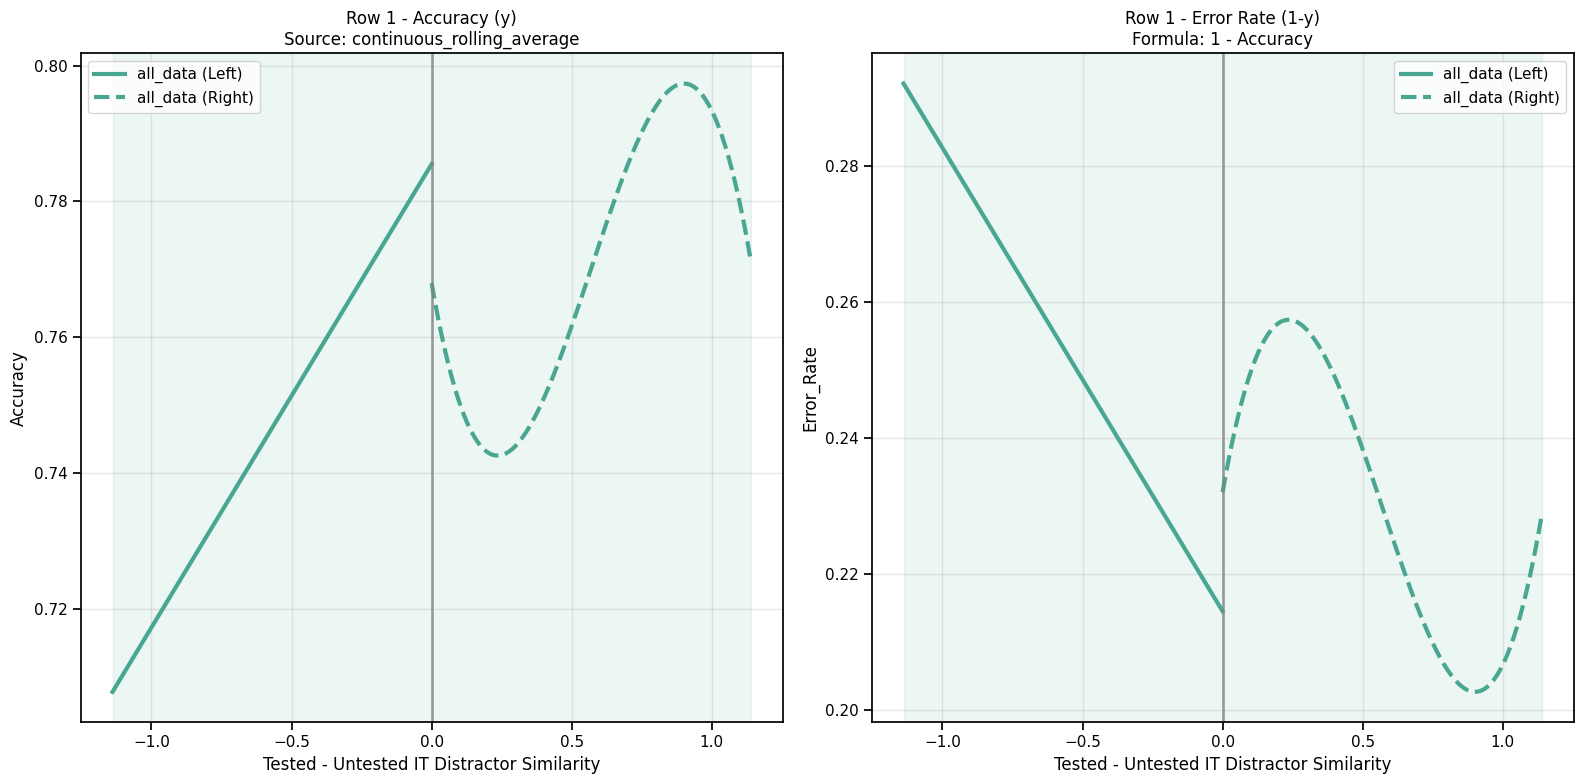

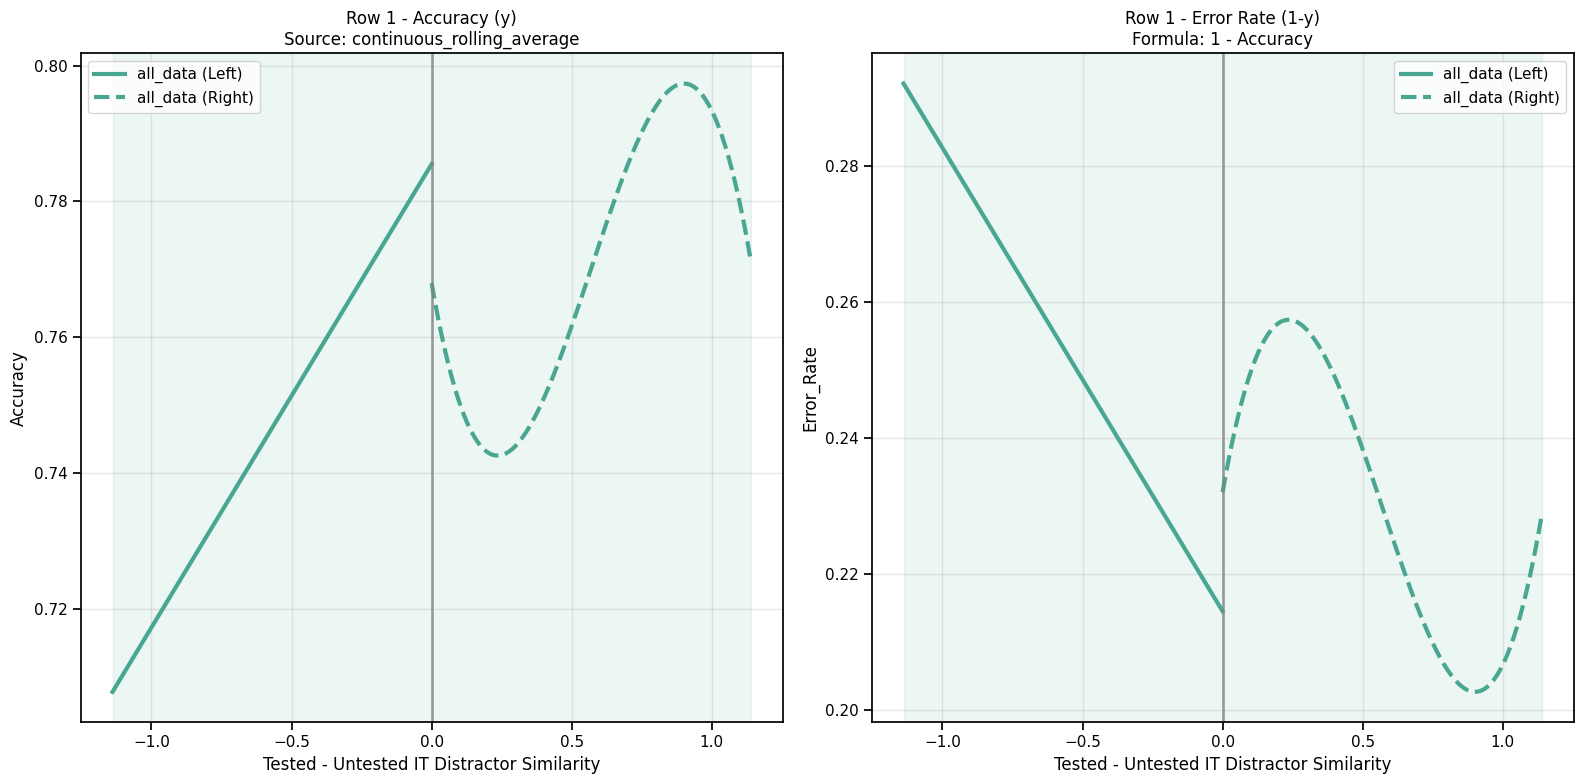

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy

def plot_combined_accuracy_fits_with_transform(accuracy_model_fits_data, row_indices=None, 
                                             figsize=(16, 8), save_plot=False, 
                                             plot_filename='combined_accuracy_fits'):
    """
    Plot accuracy model fits with both sides combined, showing both y and 1-y.
    
    Parameters:
    -----------
    accuracy_model_fits_data : dict
        Loaded accuracy model fits data
    row_indices : list, optional
        Which rows to plot (default: all rows)
    figsize : tuple, optional
        Figure size (default: (16, 8))
    save_plot : bool, optional
        Whether to save the plot (default: False)
    plot_filename : str, optional
        Filename for saved plot (default: 'combined_accuracy_fits')
    """
    
    if row_indices is None:
        row_indices = list(range(len(accuracy_model_fits_data)))
    
    # Create subplot structure: 2 columns (y, 1-y)
    num_rows = len(row_indices)
    fig, axes = plt.subplots(num_rows, 2, figsize=figsize)
    
    # Handle single row case
    if num_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, row_idx in enumerate(row_indices):
        row_key = f"row_{row_idx}"
        if row_key not in accuracy_model_fits_data:
            print(f"Warning: {row_key} not found in saved data")
            continue
            
        row_data = accuracy_model_fits_data[row_key]
        
        # Get axes
        ax_y = axes[i, 0]
        ax_1_minus_y = axes[i, 1]
        
        # Plot y (original accuracy) - both left and right sides
        # Left side (x <= 0)
        if 'left_side' in row_data['model_fits']:
            for model_key, model_info in row_data['model_fits']['left_side'].items():
                x_vals = np.array(model_info['x_values'])
                y_vals = np.array(model_info['y_values'])
                color = model_info['color']
                
                ax_y.plot(x_vals, y_vals, color=color, linewidth=3, 
                         label=f"{model_info['item_name']} (Left)")
                
                # Show the model range with light shading
                x_min, x_max = model_info['x_range_min'], model_info['x_range_max']
                ax_y.axvspan(x_min, x_max, alpha=0.1, color=color)
        
        # Right side (x >= 0)
        if 'right_side' in row_data['model_fits']:
            for model_key, model_info in row_data['model_fits']['right_side'].items():
                x_vals = np.array(model_info['x_values'])
                y_vals = np.array(model_info['y_values'])
                color = model_info['color']
                
                ax_y.plot(x_vals, y_vals, color=color, linewidth=3, 
                         linestyle='--', label=f"{model_info['item_name']} (Right)")
                
                # Show the model range with light shading
                x_min, x_max = model_info['x_range_min'], model_info['x_range_max']
                ax_y.axvspan(x_min, x_max, alpha=0.1, color=color)
        
        # Formatting for y plot
        ax_y.axvline(x=0, color='grey', linestyle='-', alpha=0.7, linewidth=2)
        source_info = row_data.get('source', 'unknown')
        ax_y.set_title(f"Row {row_idx} - Accuracy (y)\nSource: {source_info}")
        ax_y.set_xlabel(row_data['config']['x_col'])
        ax_y.set_ylabel(row_data['config']['y_col'])
        ax_y.legend()
        ax_y.grid(True, alpha=0.3)
        
        # Plot 1-y (transformed) - both left and right sides
        # Left side transformed
        if 'left_side' in row_data['model_fits']:
            for model_key, model_info in row_data['model_fits']['left_side'].items():
                x_vals = np.array(model_info['x_values'])
                y_vals = np.array(model_info['y_values'])
                y_transformed = 1 - y_vals  # Transform: 1 - y
                color = model_info['color']
                
                ax_1_minus_y.plot(x_vals, y_transformed, color=color, linewidth=3, 
                                 label=f"{model_info['item_name']} (Left)")
                
                # Show the model range with light shading
                x_min, x_max = model_info['x_range_min'], model_info['x_range_max']
                ax_1_minus_y.axvspan(x_min, x_max, alpha=0.1, color=color)
        
        # Right side transformed
        if 'right_side' in row_data['model_fits']:
            for model_key, model_info in row_data['model_fits']['right_side'].items():
                x_vals = np.array(model_info['x_values'])
                y_vals = np.array(model_info['y_values'])
                y_transformed = 1 - y_vals  # Transform: 1 - y
                color = model_info['color']
                
                ax_1_minus_y.plot(x_vals, y_transformed, color=color, linewidth=3, 
                                 linestyle='--', label=f"{model_info['item_name']} (Right)")
                
                # Show the model range with light shading
                x_min, x_max = model_info['x_range_min'], model_info['x_range_max']
                ax_1_minus_y.axvspan(x_min, x_max, alpha=0.1, color=color)
        
        # Formatting for 1-y plot
        ax_1_minus_y.axvline(x=0, color='grey', linestyle='-', alpha=0.7, linewidth=2)
        
        # Create transformed y-label
        original_y_col = row_data['config']['y_col']
        if 'accuracy' in original_y_col.lower():
            transform_y_col = original_y_col.replace('accuracy', 'error_rate').replace('Accuracy', 'Error_Rate')
        else:
            transform_y_col = f"1 - {original_y_col}"
            
        ax_1_minus_y.set_title(f"Row {row_idx} - Error Rate (1-y)\nFormula: 1 - {original_y_col}")
        ax_1_minus_y.set_xlabel(row_data['config']['x_col'])
        ax_1_minus_y.set_ylabel(transform_y_col)
        ax_1_minus_y.legend()
        ax_1_minus_y.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_plot:
        plt.savefig(f'{plot_filename}.png', dpi=300, bbox_inches='tight')
        plt.savefig(f'{plot_filename}.pdf', bbox_inches='tight')
        print(f"Combined accuracy fits plot saved as {plot_filename}.png and {plot_filename}.pdf")
    
    plt.show()
    return fig

def plot_combined_continuous_accuracy_fits_with_transform(continuous_fits_data, row_indices=None, 
                                                        figsize=(16, 8), save_plot=False, 
                                                        plot_filename='combined_continuous_accuracy_fits'):
    """
    Plot continuous accuracy model fits with both sides combined, showing both y and 1-y.
    
    Parameters:
    -----------
    continuous_fits_data : dict
        Output from create_continuous_model_fits()
    row_indices : list, optional
        Which rows to plot (default: all rows)
    figsize : tuple, optional
        Figure size (default: (16, 8))
    save_plot : bool, optional
        Whether to save the plot (default: False)
    plot_filename : str, optional
        Filename for saved plot (default: 'combined_continuous_accuracy_fits')
    """
    
    if row_indices is None:
        row_indices = list(range(len(continuous_fits_data)))
    
    # Create subplot structure: 2 columns (y, 1-y)
    num_rows = len(row_indices)
    fig, axes = plt.subplots(num_rows, 2, figsize=figsize)
    
    # Handle single row case
    if num_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, row_idx in enumerate(row_indices):
        row_key = f"row_{row_idx}"
        if row_key not in continuous_fits_data:
            continue
            
        row_data = continuous_fits_data[row_key]
        
        # Get axes
        ax_y = axes[i, 0]
        ax_1_minus_y = axes[i, 1]
        
        # Plot y (original accuracy) - Left side (x < 0)
        for model_key, model_data in row_data['continuous_left'].items():
            x_vals = np.array(model_data['x_values'])
            y_vals = np.array(model_data['y_values'])
            color = model_data['color']
            
            ax_y.plot(x_vals, y_vals, color=color, linewidth=3, 
                     label=f"{model_data['item_name']} (Left)")
            
            # Highlight original domain with thicker line
            orig_mask = (x_vals >= model_data['original_domain_min']) & (x_vals <= model_data['original_domain_max'])
            if np.any(orig_mask):
                ax_y.plot(x_vals[orig_mask], y_vals[orig_mask], color=color, linewidth=5, alpha=0.8)
        
        # Plot y (original accuracy) - Right side (x > 0)
        for model_key, model_data in row_data['continuous_right'].items():
            x_vals = np.array(model_data['x_values'])
            y_vals = np.array(model_data['y_values'])
            color = model_data['color']
            
            ax_y.plot(x_vals, y_vals, color=color, linewidth=3, linestyle='--',
                     label=f"{model_data['item_name']} (Right)")
            
            # Highlight original domain with thicker line
            orig_mask = (x_vals >= model_data['original_domain_min']) & (x_vals <= model_data['original_domain_max'])
            if np.any(orig_mask):
                ax_y.plot(x_vals[orig_mask], y_vals[orig_mask], color=color, linewidth=5, alpha=0.8)
        
        # Formatting for y plot
        ax_y.axvline(x=0, color='grey', linestyle='-', alpha=0.7, linewidth=2)
        source_info = row_data.get('source', 'unknown')
        ax_y.set_title(f"Row {row_idx} - Continuous Accuracy (y)\nSource: {source_info}")
        ax_y.set_xlabel(row_data['config']['x_col'])
        ax_y.set_ylabel(row_data['config']['y_col'])
        ax_y.legend()
        ax_y.grid(True, alpha=0.3)
        
        # Plot 1-y (transformed) - Left side (x < 0)
        for model_key, model_data in row_data['continuous_left'].items():
            x_vals = np.array(model_data['x_values'])
            y_vals = np.array(model_data['y_values'])
            y_transformed = 1 - y_vals  # Transform: 1 - y
            color = model_data['color']
            
            ax_1_minus_y.plot(x_vals, y_transformed, color=color, linewidth=3, 
                             label=f"{model_data['item_name']} (Left)")
            
            # Highlight original domain with thicker line
            orig_mask = (x_vals >= model_data['original_domain_min']) & (x_vals <= model_data['original_domain_max'])
            if np.any(orig_mask):
                ax_1_minus_y.plot(x_vals[orig_mask], y_transformed[orig_mask], color=color, linewidth=5, alpha=0.8)
        
        # Plot 1-y (transformed) - Right side (x > 0)
        for model_key, model_data in row_data['continuous_right'].items():
            x_vals = np.array(model_data['x_values'])
            y_vals = np.array(model_data['y_values'])
            y_transformed = 1 - y_vals  # Transform: 1 - y
            color = model_data['color']
            
            ax_1_minus_y.plot(x_vals, y_transformed, color=color, linewidth=3, linestyle='--',
                             label=f"{model_data['item_name']} (Right)")
            
            # Highlight original domain with thicker line
            orig_mask = (x_vals >= model_data['original_domain_min']) & (x_vals <= model_data['original_domain_max'])
            if np.any(orig_mask):
                ax_1_minus_y.plot(x_vals[orig_mask], y_transformed[orig_mask], color=color, linewidth=5, alpha=0.8)
        
        # Formatting for 1-y plot
        ax_1_minus_y.axvline(x=0, color='grey', linestyle='-', alpha=0.7, linewidth=2)
        
        # Create transformed y-label
        original_y_col = row_data['config']['y_col']
        if 'accuracy' in original_y_col.lower():
            transform_y_col = original_y_col.replace('accuracy', 'error_rate').replace('Accuracy', 'Error_Rate')
        else:
            transform_y_col = f"1 - {original_y_col}"
            
        ax_1_minus_y.set_title(f"Row {row_idx} - Continuous Error Rate (1-y)\nFormula: 1 - {original_y_col}")
        ax_1_minus_y.set_xlabel(row_data['config']['x_col'])
        ax_1_minus_y.set_ylabel(transform_y_col)
        ax_1_minus_y.legend()
        ax_1_minus_y.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_plot:
        plt.savefig(f'{plot_filename}.png', dpi=300, bbox_inches='tight')
        plt.savefig(f'{plot_filename}.pdf', bbox_inches='tight')
        print(f"Combined continuous accuracy fits plot saved as {plot_filename}.png and {plot_filename}.pdf")
    
    plt.show()
    return fig

def analyze_accuracy_fits_simple(filename_base, save_plots=False):
    """
    Simple workflow for analyzing accuracy model fits only.
    
    Parameters:
    -----------
    filename_base : str
        Base filename of saved model fits (without extension)
    save_plots : bool, optional
        Whether to save all plots (default: False)
    """
    
    print("Loading accuracy model fits...")
    accuracy_fits = load_model_fits(filename_base)
    
    print("Loaded successfully!")
    print(f"Found {len(accuracy_fits)} rows of data")
    for row_key, row_data in accuracy_fits.items():
        print(f"  {row_key}: {row_data['config']['y_col']}")
    
    print("\n1. Plotting combined accuracy fits (y and 1-y)...")
    plot_combined_accuracy_fits_with_transform(accuracy_fits, row_indices=[1], 
                                             save_plot=save_plots, 
                                             plot_filename=f'{filename_base}_combined_accuracy')
    
    print("\n2. Creating continuous extended fits...")
    continuous_accuracy = create_continuous_model_fits(accuracy_fits, x_range_extension=0.3, num_points=1000)
    
    print("3. Plotting combined continuous accuracy fits (y and 1-y)...")
    plot_combined_continuous_accuracy_fits_with_transform(continuous_accuracy, row_indices=[1],
                                                        save_plot=save_plots, 
                                                        plot_filename=f'{filename_base}_combined_continuous_accuracy')
    
    print("\nAnalysis complete!")
    
    return {
        'accuracy_fits': accuracy_fits,
        'continuous_accuracy': continuous_accuracy
    }

accuracy_fits = load_model_fits('experiment_accuracy_fits_it_pil5')
plot_combined_accuracy_fits_with_transform(accuracy_fits, row_indices=[1])




In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib.ticker import FuncFormatter, MultipleLocator
from matplotlib.gridspec import GridSpec
import pickle
import os

print("Script is running! Functions are being defined...")

def remove_leading_zero_formatter(x, pos):
    if x == 0:
        return '0'
    elif x > 0:
        formatted = f'{x:.2f}'.rstrip('0').rstrip('.')
        if formatted.startswith('0.'):
            return formatted[1:]
        return formatted
    else:
        formatted = f'{x:.2f}'.rstrip('0').rstrip('.')
        if formatted.startswith('-0.'):
            return '-' + formatted[2:]
        return formatted

def load_model_fits(filename):
    """Load model fits from pickle or json file"""
    pickle_file = f"{filename}.pkl"
    json_file = f"{filename}.json"
    
    if os.path.exists(pickle_file):
        with open(pickle_file, 'rb') as f:
            return pickle.load(f)
    elif os.path.exists(json_file):
        with open(json_file, 'r') as f:
            return json.load(f)
    else:
        raise FileNotFoundError(f"Neither {pickle_file} nor {json_file} found")

def get_data_type_from_column(x_col):
    """Determine if we're working with IT or V2 data based on column name"""
    x_col_lower = str(x_col).lower()
    
    it_patterns = ["it distractor similarity", "it_", "it similarity", "it-", "it."]
    v2_patterns = ["v2 distractor similarity", "v2_", "v2 similarity", "v2-", "v2."]
    
    for pattern in v2_patterns:
        if pattern in x_col_lower:
            return 'V2'
    
    for pattern in it_patterns:
        if pattern in x_col_lower:
            return 'IT'
    
    print(f"WARNING: Could not detect data type from column name '{x_col}'")
    return 'IT'

def get_color_for_data_type(data_type):
    """Get the appropriate color for IT or V2 data"""
    if data_type == 'IT':
        return '#A283B3'  # Purple for IT
    elif data_type == 'V2':
        return '#E58A72'  # Salmon for V2
    else:
        return '#A283B3'

def get_ltm_column_for_data_type(data_type):
    """Get the appropriate LTM column name for IT or V2 data"""
    if data_type == 'IT':
        return 'it_pos_neg_ltm'
    elif data_type == 'V2':
        return 'v2_pos_neg_ltm'
    else:
        return 'it_pos_neg_ltm'

def interpolate_model_fit_one_minus_y(model_fits_data, row_idx, side, x_values, use_first_model_only=True):
    """Interpolate 1-y values from model fits at specific x_values"""
    
    row_key = f"row_{row_idx}"
    side_key = f"{side}_side"
    
    if row_key not in model_fits_data or side_key not in model_fits_data[row_key]['model_fits']:
        return None
    
    side_data = model_fits_data[row_key]['model_fits'][side_key]
    
    if use_first_model_only:
        first_model_key = list(side_data.keys())[0]
        model_info = side_data[first_model_key]
        
        fit_x = np.array(model_info['x_values'])
        fit_y = np.array(model_info['y_values'])
        fit_one_minus_y = 1.0 - fit_y
        interpolated = np.interp(x_values, fit_x, fit_one_minus_y)
        
        return interpolated
    else:
        all_interpolated = []
        for model_key, model_info in side_data.items():
            fit_x = np.array(model_info['x_values'])
            fit_y = np.array(model_info['y_values'])
            fit_one_minus_y = 1.0 - fit_y
            interpolated = np.interp(x_values, fit_x, fit_one_minus_y)
            all_interpolated.append(interpolated)
        
        if all_interpolated:
            return np.mean(all_interpolated, axis=0)
        else:
            return None

def calculate_rolling_average_with_model_one_minus_y(df, x_col, y_col, item_col=None, 
                                                   window_percent=0.1, step_percent=0.02,
                                                   model_fits_data=None, row_idx=0):
    """Calculate rolling averages with model fits data"""
    
    it_ltm_col = 'it_pos_neg_ltm'
    v2_ltm_col = 'v2_pos_neg_ltm'
    it_ltm_available = it_ltm_col in df.columns
    v2_ltm_available = v2_ltm_col in df.columns
    
    data_type = get_data_type_from_column(x_col)
    
    if item_col is not None and item_col in df.columns:
        all_rolling_data = []
        items = df[item_col].unique()
        
        for item in items:
            df_item = df[df[item_col] == item].copy()
            df_item = df_item.sort_values(by=x_col).reset_index(drop=True)
            total_points = len(df_item)
            
            window_points = max(int(total_points * window_percent), 3)
            step_points = max(int(total_points * step_percent), 1)
            
            if total_points >= window_points:
                for j in range(0, total_points - window_points + 1, step_points):
                    window = df_item.iloc[j:j+window_points]
                    mean_x = window[x_col].mean()
                    mean_y = window[y_col].mean()
                    mean_it_ltm = window[it_ltm_col].mean() if it_ltm_available else np.nan
                    mean_v2_ltm = window[v2_ltm_col].mean() if v2_ltm_available else np.nan
                    
                    all_rolling_data.append({
                        'subject': item,
                        'x_val': mean_x,
                        'rolling_avg': mean_y,
                        'it_ltm': mean_it_ltm,
                        'v2_ltm': mean_v2_ltm
                    })
        
        if all_rolling_data:
            rolling_df = pd.DataFrame(all_rolling_data)
            rolling_df['x_bin'] = pd.cut(rolling_df['x_val'], bins=30, labels=False)
            
            x_vals, y_vals, y_errs = [], [], []
            it_ltm_vals, v2_ltm_vals = [], []
            
            for bin_idx in sorted(rolling_df['x_bin'].unique()):
                if pd.notna(bin_idx):
                    bin_data = rolling_df[rolling_df['x_bin'] == bin_idx]
                    x_vals.append(bin_data['x_val'].mean())
                    y_vals.append(bin_data['rolling_avg'].mean())
                    y_errs.append(bin_data['rolling_avg'].std() / np.sqrt(len(bin_data)))
                    it_ltm_vals.append(bin_data['it_ltm'].mean() if it_ltm_available else np.nan)
                    v2_ltm_vals.append(bin_data['v2_ltm'].mean() if v2_ltm_available else np.nan)
            
            x_vals = np.array(x_vals)
            y_vals = np.array(y_vals)
            y_errs = np.array(y_errs)
            it_ltm_vals = np.array(it_ltm_vals)
            v2_ltm_vals = np.array(v2_ltm_vals)
            
            if model_fits_data is not None:
                x_negative = x_vals[x_vals <= 0]
                x_positive = x_vals[x_vals > 0]
                one_minus_y_vals = np.full_like(x_vals, np.nan)
                
                if len(x_negative) > 0:
                    one_minus_y_left = interpolate_model_fit_one_minus_y(
                        model_fits_data, row_idx, 'left', x_negative, use_first_model_only=True
                    )
                    if one_minus_y_left is not None:
                        one_minus_y_vals[x_vals <= 0] = one_minus_y_left
                
                if len(x_positive) > 0:
                    one_minus_y_right = interpolate_model_fit_one_minus_y(
                        model_fits_data, row_idx, 'right', x_positive, use_first_model_only=True
                    )
                    if one_minus_y_right is not None:
                        one_minus_y_vals[x_vals > 0] = one_minus_y_right
                
                return x_vals, y_vals, one_minus_y_vals, it_ltm_vals, v2_ltm_vals, y_errs
            else:
                return x_vals, y_vals, None, it_ltm_vals, v2_ltm_vals, y_errs
    else:
        # Handle case with no item_col
        df_copy = df.copy().sort_values(by=x_col).reset_index(drop=True)
        total_points = len(df_copy)
        
        window_points = max(int(total_points * window_percent), 3)
        step_points = max(int(total_points * step_percent), 1)
        
        x_vals, y_vals, y_errs = [], [], []
        it_ltm_vals, v2_ltm_vals = [], []
        
        if total_points >= window_points:
            for j in range(0, total_points - window_points + 1, step_points):
                window = df_copy.iloc[j:j+window_points]
                mean_x = window[x_col].mean()
                mean_y = window[y_col].mean()
                std_y = window[y_col].std()
                sem_y = std_y / np.sqrt(window_points) if std_y > 0 else 0
                
                mean_it_ltm = window[it_ltm_col].mean() if it_ltm_available else np.nan
                mean_v2_ltm = window[v2_ltm_col].mean() if v2_ltm_available else np.nan
                
                x_vals.append(mean_x)
                y_vals.append(mean_y)
                y_errs.append(sem_y)
                it_ltm_vals.append(mean_it_ltm)
                v2_ltm_vals.append(mean_v2_ltm)
        
        x_vals = np.array(x_vals)
        y_vals = np.array(y_vals)
        y_errs = np.array(y_errs)
        it_ltm_vals = np.array(it_ltm_vals)
        v2_ltm_vals = np.array(v2_ltm_vals)
        
        if model_fits_data is not None:
            x_negative = x_vals[x_vals <= 0]
            x_positive = x_vals[x_vals > 0]
            
            one_minus_y_vals = np.full_like(x_vals, np.nan)
            
            if len(x_negative) > 0:
                one_minus_y_left = interpolate_model_fit_one_minus_y(
                    model_fits_data, row_idx, 'left', x_negative, use_first_model_only=True
                )
                if one_minus_y_left is not None:
                    one_minus_y_vals[x_vals <= 0] = one_minus_y_left
            
            if len(x_positive) > 0:
                one_minus_y_right = interpolate_model_fit_one_minus_y(
                    model_fits_data, row_idx, 'right', x_positive, use_first_model_only=True
                )
                if one_minus_y_right is not None:
                    one_minus_y_vals[x_vals > 0] = one_minus_y_right
            
            return x_vals, y_vals, one_minus_y_vals, it_ltm_vals, v2_ltm_vals, y_errs
        else:
            return x_vals, y_vals, None, it_ltm_vals, v2_ltm_vals, y_errs

def create_continuous_rolling_plot_with_one_minus_y_regression(df, x_col, y_col, item_col=None, 
                                                             window_percent=0.1, step_percent=0.02,
                                                             ax=None, 
                                                             y_limits=None, x_limits=None,
                                                             x_tick_step=None, y_tick_step=None,
                                                             y_as_percentage=False, y_percentage_step=2,
                                                             font_family='Arial',
                                                             label_font_size=16, tick_font_size=14,
                                                             line_width=1, confidence_alpha=0.2,
                                                             model_fits_data=None, row_idx=0,
                                                             plot_model_fits=True):
    
    data_type = get_data_type_from_column(x_col)
    color = get_color_for_data_type(data_type)
    
    result = calculate_rolling_average_with_model_one_minus_y(
        df, x_col, y_col, item_col, window_percent, step_percent, model_fits_data, row_idx
    )
    
    if len(result) == 6:
        x_vals, y_vals, one_minus_y_vals, it_ltm_vals, v2_ltm_vals, y_errs = result
    else:
        x_vals, y_vals, one_minus_y_vals, y_errs = result
        it_ltm_vals = None
        v2_ltm_vals = None
    
    if len(x_vals) == 0:
        return ax, None, None, None
    
    # Plot rolling averages
    ax.plot(x_vals, y_vals, color=color, linewidth=line_width, alpha=0.9, label='Rolling average')
    ax.fill_between(x_vals, y_vals - 1.96 * y_errs, y_vals + 1.96 * y_errs,
                   color=color, alpha=confidence_alpha)
    
    fitted_line_data = None
    regression_model = None
    
    # Fit regression model if requested
    if one_minus_y_vals is not None and plot_model_fits:
        valid_mask = ~np.isnan(one_minus_y_vals)
        
        if np.sum(valid_mask) > 5:
            try:
                if data_type in ['IT', 'V2']:
                    matching_ltm_vals = np.where(x_vals <= 0, -1.0, 1.0)
                    predictors = [one_minus_y_vals[valid_mask], matching_ltm_vals[valid_mask]]
                    predictor_names = ['(1-y_values)', f'{data_type}_LTM_fixed']
                else:
                    predictors = [one_minus_y_vals[valid_mask]]
                    predictor_names = ['(1-y_values)']
                
                x_valid = x_vals[valid_mask]
                y_valid = y_vals[valid_mask]
                
                if len(y_valid) > len(predictor_names) + 2:
                    if len(predictors) == 1:
                        X = predictors[0].reshape(-1, 1)
                    else:
                        X = np.column_stack(predictors)
                    X = sm.add_constant(X)
                    
                    regression_model = sm.OLS(y_valid, X).fit()
                    
                    sort_indices = np.argsort(x_valid)
                    x_sorted = x_valid[sort_indices]
                    X_sorted = X[sort_indices]
                    y_pred = regression_model.predict(X_sorted)
                    
                    fitted_line_data = {
                        'x_values': x_sorted.copy(),
                        'y_values': y_pred.copy(),
                        'predictor_names': predictor_names.copy(),
                        'data_type': data_type
                    }
            except Exception as e:
                print(f"Regression failed: {e}")
    
    # Add vertical line at x=0
    ax.axvline(x=0, color='grey', linestyle='--', alpha=0.7, linewidth=3)
    
    # Set axis properties
    if x_limits is not None:
        ax.set_xlim(x_limits)
    if y_limits is not None:
        ax.set_ylim(y_limits)
    
    if x_tick_step is not None:
        ax.xaxis.set_major_locator(MultipleLocator(x_tick_step))
    if y_tick_step is not None:
        ax.yaxis.set_major_locator(MultipleLocator(y_tick_step))
    
    # Format axes
    ax.xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    spine_color = '#B8B8B8'
    ax.tick_params(axis='x', colors=spine_color, labelsize=tick_font_size, labelcolor='black')
    ax.tick_params(axis='y', colors=spine_color, labelsize=tick_font_size, labelcolor='black')
    
    for label in ax.get_xticklabels():
        label.set_fontfamily(font_family)
    for label in ax.get_yticklabels():
        label.set_fontfamily(font_family)
    
    rolling_average_data = {
        'x_values': x_vals.copy(),
        'y_values': y_vals.copy(),
        'y_errors': y_errs.copy()
    }
    
    return ax, regression_model, fitted_line_data, rolling_average_data

def create_single_side_plot_simple(df, x_col, y_col, item_col=None, 
                                  split_value=0, side='left',
                                  window_percent=0.2, step_percent=0.02,
                                  ax=None,
                                  y_limits=None, x_limits=None,
                                  x_tick_step=None, y_tick_step=None,
                                  y_as_percentage=False, y_percentage_step=2,
                                  x_buffer_percent=0.05,
                                  font_family='Arial',
                                  label_font_size=16, label_font_weight='bold', label_font_color='black',
                                  tick_font_size=14, tick_font_color='black',
                                  rolling_line_width=1,
                                  confidence_alpha=0.2, rolling_alpha=0.9,
                                  show_ylabel=True, show_xlabel=True,
                                  fitted_line_data=None, rolling_average_data=None,
                                  y_label=None, plot_model_fits=True):
    
    teal = '#49a791'
    grey = '#BFBFBF'
    
    data_type = get_data_type_from_column(x_col)
    primary_color = get_color_for_data_type(data_type)
    
    ax.set_facecolor('white')
    
    if side == 'left':
        df_side = df[df[x_col] <= split_value].copy()
    else:
        df_side = df[df[x_col] > split_value].copy()
    
    # Plot rolling averages using shared data
    if rolling_average_data is not None:
        all_x_vals = rolling_average_data['x_values']
        all_y_vals = rolling_average_data['y_values']
        all_y_errs = rolling_average_data['y_errors']
        
        if side == 'left':
            mask = all_x_vals <= split_value
        else:
            mask = all_x_vals > split_value
        
        if np.any(mask):
            x_vals = all_x_vals[mask]
            y_vals = all_y_vals[mask]
            y_errs = all_y_errs[mask]
            
            ax.plot(x_vals, y_vals, color=primary_color, linewidth=1, 
                   alpha=rolling_alpha, label='Rolling average')
            ax.fill_between(x_vals, y_vals - 1.96 * y_errs, y_vals + 1.96 * y_errs,
                           color=primary_color, alpha=confidence_alpha)
    
    # Add regression line from fitted line data
    if fitted_line_data is not None and plot_model_fits:
        fit_x = fitted_line_data['x_values']
        fit_y = fitted_line_data['y_values']
        
        if side == 'left':
            mask = fit_x <= split_value
        else:
            mask = fit_x > split_value
        
        if np.any(mask):
            side_x = fit_x[mask]
            side_y = fit_y[mask]
            
            if len(side_x) > 0:
                ax.plot(side_x, side_y, color=teal, linestyle='--', 
                        linewidth=6, alpha=0.8, label='WM competition')
    
    # Set labels
    if show_xlabel:
        if data_type == 'IT':
            ax.set_xlabel("Relative IT Similarity", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, 
                         fontfamily=font_family, labelpad=15)
        elif data_type == 'V2':
            ax.set_xlabel("Relative V2 Similarity", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color,
                         fontfamily=font_family, labelpad=15)
    else:
        ax.set_xlabel('')
    
    if show_ylabel:
        if y_label is not None:
            ax.set_ylabel(y_label, fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color,
                         fontfamily=font_family, labelpad=15)
        elif y_col.lower() in ['accuracy']:
            if y_as_percentage:
                ax.set_ylabel("Choice Accuracy (% Correct)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color,
                             fontfamily=font_family, labelpad=15)
                ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
                if y_tick_step is None:
                    y_tick_step = y_percentage_step / 100.0
            else:
                ax.set_ylabel("Choice Accuracy (% Correct)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color,
                             fontfamily=font_family, labelpad=15)
    
    # Set tick parameters
    if x_tick_step is not None:
        ax.xaxis.set_major_locator(MultipleLocator(x_tick_step))
    if y_tick_step is not None:
        ax.yaxis.set_major_locator(MultipleLocator(y_tick_step))
    
    # Handle x-limits with buffer
    if x_limits is not None:
        if side == 'left':
            x_min, x_max = x_limits[0], split_value
            x_range = abs(x_max - x_min)
            buffer = x_range * x_buffer_percent
            ax.set_xlim(x_min - buffer, x_max)
        else:
            x_min, x_max = split_value, x_limits[1]
            x_range = abs(x_max - x_min)
            buffer = x_range * x_buffer_percent
            ax.set_xlim(x_min - buffer, x_max)
    
    if y_limits is not None:
        ax.set_ylim(y_limits)
    
    ax.xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    spine_color = '#B8B8B8'
    ax.tick_params(axis='x', colors=spine_color, labelsize=tick_font_size, labelcolor=tick_font_color)
    ax.tick_params(axis='y', colors=spine_color, labelsize=tick_font_size, labelcolor=tick_font_color)
    
    for label in ax.get_xticklabels():
        label.set_fontfamily(font_family)
    for label in ax.get_yticklabels():
        label.set_fontfamily(font_family)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color(spine_color)
    ax.spines['left'].set_color(spine_color)
    ax.spines['bottom'].set_linewidth(5)
    ax.spines['left'].set_linewidth(5)
    ax.grid(False)
    
    return ax

def create_three_panel_visualization(plot_configs, middle_width=0.35, middle_height_shift=0.0, 
                                   middle_size_scale=0.7, adjustable_gap=0.01, 
                                   x_buffer_percent=0.05,
                                   model_fits_data=None,
                                   plot_model_fits=True):
    """
    Create single-row three-panel visualization.
    COLORS: IT data uses #A283B3 (purple), V2 data uses #E58A72 (salmon)
    Model fits: Teal (#49a791) dashed lines
    """
    
    # EXACT SIZING FROM DOCUMENT 2
    fig = plt.figure(figsize=(18, 6.3))
    
    original_gap_width = 0.01
    original_remaining_width = 1.0 - middle_width - 2*original_gap_width
    fixed_side_width = original_remaining_width / 2 * 0.6
    fixed_middle_width = middle_width
    
    current_gap_width = adjustable_gap
    
    total_plot_width = 2 * fixed_side_width + fixed_middle_width + 2 * current_gap_width
    remaining_for_margins = 1.0 - total_plot_width
    outer_margin = remaining_for_margins / 2
    
    if outer_margin < 0.001:
        outer_margin = 0.001
    
    gs = GridSpec(1, 7, figure=fig, 
                  width_ratios=[outer_margin, fixed_side_width, current_gap_width, fixed_middle_width, current_gap_width, fixed_side_width, outer_margin],  
                  height_ratios=[1],   # Single row
                  hspace=0.25, wspace=0.01,  # No vertical spacing needed
                  top=0.95, bottom=0.1, left=0.05, right=0.95)  # Tight vertical margins


   
    # Create axes
    ax_left = fig.add_subplot(gs[0, 1])
    ax_middle = fig.add_subplot(gs[0, 3])
    ax_right = fig.add_subplot(gs[0, 5])
    axes = [ax_left, ax_middle, ax_right]
    
    # Process first config only
    config = plot_configs[0]
    row = 0
    
    x_col = config['x_col']
    data_type = get_data_type_from_column(x_col)
    frame_color = get_color_for_data_type(data_type)
    y_limits = config.get('y_limits')
    
    # Middle panel
    ax_middle_result = create_continuous_rolling_plot_with_one_minus_y_regression(
        config['df'],
        x_col=config['x_col'],
        y_col=config['y_col'],
        item_col=config.get('item_col'),
        ax=axes[1],
        y_limits=y_limits,
        x_limits=config.get('x_limits'),
        x_tick_step=config.get('x_tick_step'),
        y_tick_step=config.get('y_tick_step'),
        y_as_percentage=config.get('y_as_percentage', False),
        y_percentage_step=config.get('y_percentage_step', 2),
        font_family=config.get('font_family', 'Arial'),
        label_font_size=config.get('label_font_size', 16),
        tick_font_size=config.get('tick_font_size', 14),
        window_percent=0.1,
        step_percent=0.01,
        line_width=2,
        model_fits_data=model_fits_data,
        row_idx=row + 1,
        plot_model_fits=plot_model_fits
    )
    
    if config.get('y_as_percentage', False):
        axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
    
    if isinstance(ax_middle_result, tuple) and len(ax_middle_result) == 4:
        _, regression_model, fitted_line_data, rolling_average_data = ax_middle_result
    else:
        fitted_line_data = None
        rolling_average_data = None
    
    # Style middle panel - KEEP ALL BORDERS
    axes[1].set_xlabel('')
    axes[1].tick_params(axis='x', labelbottom=False, which='both')
    axes[1].set_xticks([])
    
    # Keep ALL spines visible with frame color
    for spine_name, spine in axes[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(5)
        spine.set_color(frame_color)
    
    axes[1].set_facecolor('#f8f8f8')
    
    pos = axes[1].get_position()
    new_width = pos.width * middle_size_scale
    new_height = pos.height * middle_size_scale
    new_x = pos.x0 + (pos.width - new_width) / 2
    new_y = pos.y0 + middle_height_shift  # Changed from: pos.y0 + (pos.height - new_height) / 2
    
    new_pos = [new_x, new_y, new_width, new_height]
    axes[1].set_position(new_pos)

    
    # Left panel
    create_single_side_plot_simple(
        config['df'],
        x_col=config['x_col'],
        y_col=config['y_col'],
        item_col=config.get('item_col'),
        side='left',
        ax=axes[0],
        y_limits=y_limits,
        x_limits=config.get('x_limits'),
        x_tick_step=config.get('x_tick_step'),
        y_tick_step=config.get('y_tick_step'),
        window_percent=0.2,
        step_percent=0.02,
        y_as_percentage=config.get('y_as_percentage', False),
        y_percentage_step=config.get('y_percentage_step', 2),
        x_buffer_percent=x_buffer_percent,
        font_family=config.get('font_family', 'Arial'),
        label_font_size=config.get('label_font_size', 16),
        tick_font_size=config.get('tick_font_size', 14),
        show_ylabel=True,
        show_xlabel=False,
        fitted_line_data=fitted_line_data,
        rolling_average_data=rolling_average_data,
        y_label=config.get('y_label'),
        plot_model_fits=plot_model_fits
    )
    
    if config.get('y_as_percentage', False):
        axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
    
    # Right panel
    create_single_side_plot_simple(
        config['df'],
        x_col=config['x_col'],
        y_col=config['y_col'],
        item_col=config.get('item_col'),
        side='right',
        ax=axes[2],
        y_limits=y_limits,
        x_limits=config.get('x_limits'),
        x_tick_step=config.get('x_tick_step'),
        y_tick_step=config.get('y_tick_step'),
        window_percent=0.2,
        step_percent=0.02,
        y_as_percentage=config.get('y_as_percentage', False),
        y_percentage_step=config.get('y_percentage_step', 2),
        x_buffer_percent=x_buffer_percent,
        font_family=config.get('font_family', 'Arial'),
        label_font_size=config.get('label_font_size', 16),
        tick_font_size=config.get('tick_font_size', 14),
        show_ylabel=False,
        show_xlabel=False,
        fitted_line_data=fitted_line_data,
        rolling_average_data=rolling_average_data,
        y_label=config.get('y_label'),
        plot_model_fits=plot_model_fits
    )
    
    if config.get('y_as_percentage', False):
        axes[2].yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
    
    # Clean up axes
    axes[1].set_ylabel('')
    axes[1].tick_params(axis='y', labelleft=False, left=False)
    
    axes[2].set_ylabel('')
    axes[2].tick_params(axis='y', labelleft=False, left=False)
    axes[2].spines['left'].set_visible(False)
    
    axes[0].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    axes[2].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    plt.show()
    return fig

Script is running! Functions are being defined...


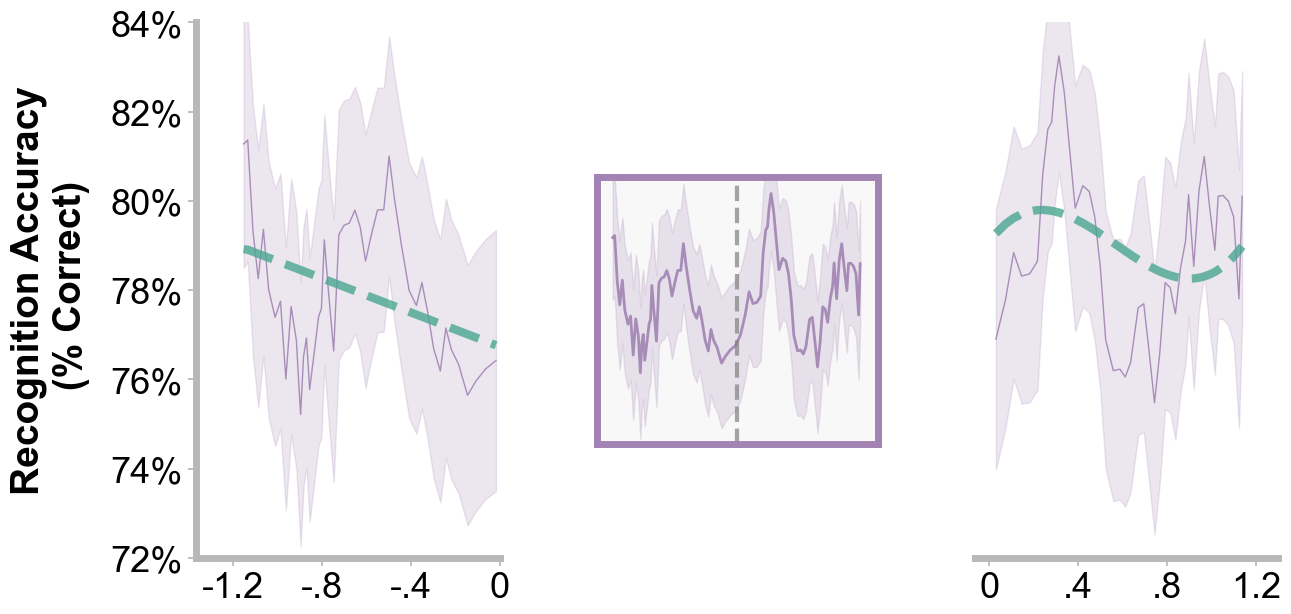

In [17]:

plot_configs_it_fixed = [
    {
        'df': df,
        'x_col': 'LTM - NonLTM IT Distractor Similarity',
        'y_col': "LTM Accuracy",
        # 'item_col': "Tested Item",
        'y_label': "Recognition Accuracy\n (% Correct)",

        'split_col': "IT_pos_neg",
        'split_value': 0.7,
        'y_limits': (0.72, 0.84),
        'x_limits': (-1.3, 1.3),
        'x_tick_step': 0.4,
        'left_model_order': 1,
        'right_model_order': 3,
        'trim_percentile': 0,
        'y_as_percentage': True,
        'y_percentage_step': 2,
        'font_family': 'Arial',
        'label_font_size': 28,  # UPDATED: Match second code
        'tick_font_size': 26    # UPDATED: Match second code
    }
]
plot_configs_v2 = [
    {
        'df': df,
        'x_col': 'LTM - NonLTM V2 Distractor Similarity',
        'y_col': "LTM Accuracy",
        'y_label': "Recognition Accuracy\n (% Correct)",
        'split_col': "V2_pos_neg",
        'split_value': 0,
        'y_limits': (0.72, 0.84), # Custom y-axis limits
        'x_limits': (-0.17, 0.17),   # Combined x limits
        'x_tick_step': 0.06,           # X-axis ticks every 0.04
        'left_model_order': 3,         # 3rd order polynomial for left side
        'right_model_order': 3,        # 3rd order polynomial for right side
        'trim_percentile': 0,          # Remove extreme 0% from each tail
        'y_as_percentage': True,       # Format as percentages
        'y_percentage_step': 2,        # Every 2%
        'font_family': 'Arial',
        'label_font_size': 28,         # Increased from 14
        'tick_font_size': 26           # Increased from 12
    }

]






model_fits_it = load_model_fits('experiment_accuracy_fits_it_pil5')
model_fits_v2 = load_model_fits('experiment_accuracy_fits_v2_pil5')
# Call the function with the updated settings to match second code
fig_it = create_three_panel_visualization(
    plot_configs_it_fixed,
    middle_width=0.35,
    middle_height_shift=0.18,
    middle_size_scale=0.5,
    adjustable_gap=-0.03,
    x_buffer_percent=0.05,
    model_fits_data=model_fits_it  # Only IT model fits
)




In [18]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# import statsmodels.api as sm
# from matplotlib.ticker import FuncFormatter, MultipleLocator
# from matplotlib.gridspec import GridSpec

# def remove_leading_zero_formatter(x, pos):
#     if x == 0:
#         return '0'
#     elif x > 0:
#         formatted = f'{x:.2f}'.rstrip('0').rstrip('.')
#         if formatted.startswith('0.'):
#             return formatted[1:]
#         return formatted
#     else:
#         formatted = f'{x:.2f}'.rstrip('0').rstrip('.')
#         if formatted.startswith('-0.'):
#             return '-' + formatted[2:]
#         return formatted

# def get_data_type_from_column(x_col):
#     """Determine if we're working with IT or V2 data based on column name"""
#     x_col_lower = str(x_col).lower()
    
#     it_patterns = ["it distractor similarity", "it_", "it similarity", "it-", "it."]
#     v2_patterns = ["v2 distractor similarity", "v2_", "v2 similarity", "v2-", "v2."]
    
#     for pattern in v2_patterns:
#         if pattern in x_col_lower:
#             return 'V2'
    
#     for pattern in it_patterns:
#         if pattern in x_col_lower:
#             return 'IT'
    
#     return 'IT'

# def get_color_for_data_type(data_type):
#     """Get the appropriate color for IT or V2 data"""
#     if data_type == 'IT':
#         return '#A283B3'  # Purple for IT
#     elif data_type == 'V2':
#         return '#E58A72'  # Salmon for V2
#     else:
#         return '#A283B3'

# def get_flipped_column_for_data_type(data_type):
#     """Get the appropriate flipped column name for IT or V2 data"""
#     if data_type == 'IT':
#         return 'rolling_it_flipped'
#     elif data_type == 'V2':
#         return 'rolling_v2_flipped'
#     else:
#         return 'rolling_it_flipped'

# def get_ltm_column_for_data_type(data_type):
#     """Get the appropriate LTM column name for IT or V2 data"""
#     if data_type == 'IT':
#         return 'it_pos_neg_ltm'
#     elif data_type == 'V2':
#         return 'v2_pos_neg_ltm'
#     else:
#         return 'it_pos_neg_ltm'

# def calculate_rolling_average_with_flipped(df, x_col, y_col, item_col=None, 
#                                            window_percent=0.1, step_percent=0.02):
#     """Calculate rolling averages including flipped and LTM values"""
    
#     data_type = get_data_type_from_column(x_col)
#     flipped_col = get_flipped_column_for_data_type(data_type)
#     ltm_col = get_ltm_column_for_data_type(data_type)
    
#     flipped_available = flipped_col in df.columns
#     ltm_available = ltm_col in df.columns
    
#     if item_col is not None and item_col in df.columns:
#         all_rolling_data = []
#         items = df[item_col].unique()
        
#         for item in items:
#             df_item = df[df[item_col] == item].copy()
#             df_item = df_item.sort_values(by=x_col).reset_index(drop=True)
#             total_points = len(df_item)
            
#             window_points = max(int(total_points * window_percent), 3)
#             step_points = max(int(total_points * step_percent), 1)
            
#             if total_points >= window_points:
#                 for j in range(0, total_points - window_points + 1, step_points):
#                     window = df_item.iloc[j:j+window_points]
#                     mean_x = window[x_col].mean()
#                     mean_y = window[y_col].mean()
#                     mean_flipped = window[flipped_col].mean() if flipped_available else np.nan
#                     mean_ltm = window[ltm_col].mean() if ltm_available else np.nan
                    
#                     all_rolling_data.append({
#                         'subject': item,
#                         'x_val': mean_x,
#                         'rolling_avg': mean_y,
#                         'flipped_val': mean_flipped,
#                         'ltm_val': mean_ltm
#                     })
        
#         if all_rolling_data:
#             rolling_df = pd.DataFrame(all_rolling_data)
#             rolling_df['x_bin'] = pd.cut(rolling_df['x_val'], bins=30, labels=False)
            
#             x_vals, y_vals, y_errs, flipped_vals, ltm_vals = [], [], [], [], []
            
#             for bin_idx in sorted(rolling_df['x_bin'].unique()):
#                 if pd.notna(bin_idx):
#                     bin_data = rolling_df[rolling_df['x_bin'] == bin_idx]
#                     x_vals.append(bin_data['x_val'].mean())
#                     y_vals.append(bin_data['rolling_avg'].mean())
#                     y_errs.append(bin_data['rolling_avg'].std() / np.sqrt(len(bin_data)))
#                     flipped_vals.append(bin_data['flipped_val'].mean() if flipped_available else np.nan)
#                     ltm_vals.append(bin_data['ltm_val'].mean() if ltm_available else np.nan)
            
#             return (np.array(x_vals), np.array(y_vals), np.array(flipped_vals), 
#                     np.array(ltm_vals), np.array(y_errs))
#     else:
#         df_copy = df.copy().sort_values(by=x_col).reset_index(drop=True)
#         total_points = len(df_copy)
        
#         window_points = max(int(total_points * window_percent), 3)
#         step_points = max(int(total_points * step_percent), 1)
        
#         x_vals, y_vals, y_errs, flipped_vals, ltm_vals = [], [], [], [], []
        
#         if total_points >= window_points:
#             for j in range(0, total_points - window_points + 1, step_points):
#                 window = df_copy.iloc[j:j+window_points]
#                 mean_x = window[x_col].mean()
#                 mean_y = window[y_col].mean()
#                 std_y = window[y_col].std()
#                 sem_y = std_y / np.sqrt(window_points) if std_y > 0 else 0
#                 mean_flipped = window[flipped_col].mean() if flipped_available else np.nan
#                 mean_ltm = window[ltm_col].mean() if ltm_available else np.nan
                
#                 x_vals.append(mean_x)
#                 y_vals.append(mean_y)
#                 y_errs.append(sem_y)
#                 flipped_vals.append(mean_flipped)
#                 ltm_vals.append(mean_ltm)
        
#         return (np.array(x_vals), np.array(y_vals), np.array(flipped_vals), 
#                 np.array(ltm_vals), np.array(y_errs))


# def create_continuous_rolling_plot_with_regression(df, x_col, y_col, item_col=None, 
#                                                    window_percent=0.1, step_percent=0.02,
#                                                    ax=None, 
#                                                    y_limits=None, x_limits=None,
#                                                    x_tick_step=None, y_tick_step=None,
#                                                    y_as_percentage=False, y_percentage_step=2,
#                                                    font_family='Arial',
#                                                    label_font_size=16, tick_font_size=14,
#                                                    line_width=1, confidence_alpha=0.2,
#                                                    plot_model_fits=True):
    
#     data_type = get_data_type_from_column(x_col)
#     color = get_color_for_data_type(data_type)
    
#     x_vals, y_vals, flipped_vals, ltm_vals, y_errs = calculate_rolling_average_with_flipped(
#         df, x_col, y_col, item_col, window_percent, step_percent
#     )
    
#     if len(x_vals) == 0:
#         return ax, None, None, None
    
#     # Plot rolling averages
#     ax.plot(x_vals, y_vals, color=color, linewidth=line_width, alpha=0.9, label='Rolling average')
#     ax.fill_between(x_vals, y_vals - 1.96 * y_errs, y_vals + 1.96 * y_errs,
#                    color=color, alpha=confidence_alpha)
    
#     fitted_line_data = None
#     regression_model = None
    
#     if plot_model_fits:
#         valid_mask = ~np.isnan(flipped_vals)
        
#         if np.sum(valid_mask) > 5:
#             try:
#                 # Prepare data
#                 x_valid = x_vals[valid_mask]
#                 y_valid = y_vals[valid_mask]
#                 flipped_valid = flipped_vals[valid_mask]
                
#                 # LTM: use actual values or default to -1/+1 based on x position
#                 if not np.all(np.isnan(ltm_vals)):
#                     ltm_valid = ltm_vals[valid_mask]
#                     ltm_valid = np.where(np.isnan(ltm_valid), 
#                                         np.where(x_valid <= 0, -1.0, 1.0),
#                                         ltm_valid)
#                 else:
#                     ltm_valid = np.where(x_valid <= 0, -1.0, 1.0)
                
#                 predictor_names = [f'{data_type}_flipped', f'{data_type}_LTM']
                
#                 # Fit regression on ALL data together
#                 X = np.column_stack([flipped_valid, ltm_valid])
#                 X = sm.add_constant(X)
#                 regression_model = sm.OLS(y_valid, X).fit()
                
#                 print(f"\n{data_type} Regression Results:")
#                 print(f"R-squared: {regression_model.rsquared:.4f}")
#                 for i, name in enumerate(['const'] + predictor_names):
#                     print(f"  {name}: {regression_model.params[i]:.6f} (p={regression_model.pvalues[i]:.4f})")
                
#                 # LEFT SIDE - predict at original x values
#                 left_mask = x_valid <= 0
#                 x_left = x_valid[left_mask]
#                 flipped_left = flipped_valid[left_mask]
#                 ltm_left = ltm_valid[left_mask]
                
#                 if len(x_left) > 0:
#                     sort_idx = np.argsort(x_left)
#                     x_left_sorted = x_left[sort_idx]
#                     flipped_left_sorted = flipped_left[sort_idx]
#                     ltm_left_sorted = ltm_left[sort_idx]
                    
#                     # Add constant for prediction
#                     X_left = sm.add_constant(np.column_stack([flipped_left_sorted, ltm_left_sorted]))
#                     y_pred_left = regression_model.predict(X_left)
#                 else:
#                     x_left_sorted = np.array([])
#                     y_pred_left = np.array([])
                
#                 # RIGHT SIDE - predict at original x values
#                 right_mask = x_valid > 0
#                 x_right = x_valid[right_mask]
#                 flipped_right = flipped_valid[right_mask]
#                 ltm_right = ltm_valid[right_mask]
                
#                 if len(x_right) > 0:
#                     sort_idx = np.argsort(x_right)
#                     x_right_sorted = x_right[sort_idx]
#                     flipped_right_sorted = flipped_right[sort_idx]
#                     ltm_right_sorted = ltm_right[sort_idx]
                    
#                     # Add constant for prediction
#                     X_right = sm.add_constant(np.column_stack([flipped_right_sorted, ltm_right_sorted]))
#                     y_pred_right = regression_model.predict(X_right)
#                 else:
#                     x_right_sorted = np.array([])
#                     y_pred_right = np.array([])
                
#                 fitted_line_data = {
#                     'x_values_left': x_left_sorted,
#                     'y_values_left': y_pred_left,
#                     'x_values_right': x_right_sorted,
#                     'y_values_right': y_pred_right,
#                     'predictor_names': predictor_names,
#                     'data_type': data_type
#                 }
                    
#             except Exception as e:
#                 print(f"Regression failed: {e}")
#                 import traceback
#                 traceback.print_exc()
    
#     # Add vertical line at x=0
#     ax.axvline(x=0, color='grey', linestyle='--', alpha=0.7, linewidth=3)
    
#     if x_limits is not None:
#         ax.set_xlim(x_limits)
#     if y_limits is not None:
#         ax.set_ylim(y_limits)
    
#     if x_tick_step is not None:
#         ax.xaxis.set_major_locator(MultipleLocator(x_tick_step))
#     if y_tick_step is not None:
#         ax.yaxis.set_major_locator(MultipleLocator(y_tick_step))
    
#     ax.xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
#     spine_color = '#B8B8B8'
#     ax.tick_params(axis='x', colors=spine_color, labelsize=tick_font_size, labelcolor='black')
#     ax.tick_params(axis='y', colors=spine_color, labelsize=tick_font_size, labelcolor='black')
    
#     for label in ax.get_xticklabels():
#         label.set_fontfamily(font_family)
#     for label in ax.get_yticklabels():
#         label.set_fontfamily(font_family)
    
#     rolling_average_data = {
#         'x_values': x_vals.copy(),
#         'y_values': y_vals.copy(),
#         'y_errors': y_errs.copy()
#     }
    
#     return ax, regression_model, fitted_line_data, rolling_average_data


# def create_single_side_plot_simple(df, x_col, y_col, item_col=None, 
#                                   split_value=0, side='left',
#                                   window_percent=0.2, step_percent=0.02,
#                                   ax=None,
#                                   y_limits=None, x_limits=None,
#                                   x_tick_step=None, y_tick_step=None,
#                                   y_as_percentage=False, y_percentage_step=2,
#                                   x_buffer_percent=0.05,
#                                   font_family='Arial',
#                                   label_font_size=16, label_font_weight='bold', label_font_color='black',
#                                   tick_font_size=14, tick_font_color='black',
#                                   rolling_line_width=1,
#                                   confidence_alpha=0.2, rolling_alpha=0.9,
#                                   show_ylabel=True, show_xlabel=True,
#                                   fitted_line_data=None, rolling_average_data=None,
#                                   y_label=None, plot_model_fits=True):
    
#     teal = '#49a791'
    
#     data_type = get_data_type_from_column(x_col)
#     primary_color = get_color_for_data_type(data_type)
    
#     ax.set_facecolor('white')
    
#     # Plot rolling averages using shared data
#     if rolling_average_data is not None:
#         all_x_vals = rolling_average_data['x_values']
#         all_y_vals = rolling_average_data['y_values']
#         all_y_errs = rolling_average_data['y_errors']
        
#         if side == 'left':
#             mask = all_x_vals <= split_value
#         else:
#             mask = all_x_vals > split_value
        
#         if np.any(mask):
#             x_vals = all_x_vals[mask]
#             y_vals = all_y_vals[mask]
#             y_errs = all_y_errs[mask]
            
#             ax.plot(x_vals, y_vals, color=primary_color, linewidth=1, 
#                    alpha=rolling_alpha, label='Rolling average')
#             ax.fill_between(x_vals, y_vals - 1.96 * y_errs, y_vals + 1.96 * y_errs,
#                            color=primary_color, alpha=confidence_alpha)
    
#     # Add regression fitted line
#     if fitted_line_data is not None and plot_model_fits:
#         if side == 'left':
#             fit_x = fitted_line_data.get('x_values_left', np.array([]))
#             fit_y = fitted_line_data.get('y_values_left', np.array([]))
#         else:
#             fit_x = fitted_line_data.get('x_values_right', np.array([]))
#             fit_y = fitted_line_data.get('y_values_right', np.array([]))
        
#         if len(fit_x) > 0 and len(fit_y) > 0:
#             ax.plot(fit_x, fit_y, color=teal, linestyle='--', 
#                     linewidth=6, alpha=0.8, label='WM competition')
    
#     # Set labels
#     if show_xlabel:
#         if data_type == 'IT':
#             ax.set_xlabel("Relative IT Similarity", fontweight=label_font_weight, 
#                          fontsize=label_font_size, color=label_font_color, 
#                          fontfamily=font_family, labelpad=15)
#         elif data_type == 'V2':
#             ax.set_xlabel("Relative V2 Similarity", fontweight=label_font_weight, 
#                          fontsize=label_font_size, color=label_font_color,
#                          fontfamily=font_family, labelpad=15)
#     else:
#         ax.set_xlabel('')
    
#     if show_ylabel:
#         if y_label is not None:
#             ax.set_ylabel(y_label, fontweight=label_font_weight, 
#                          fontsize=label_font_size, color=label_font_color,
#                          fontfamily=font_family, labelpad=15)
#         elif y_col.lower() in ['accuracy']:
#             if y_as_percentage:
#                 ax.set_ylabel("Choice Accuracy (% Correct)", fontweight=label_font_weight, 
#                              fontsize=label_font_size, color=label_font_color,
#                              fontfamily=font_family, labelpad=15)
#                 ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
#                 if y_tick_step is None:
#                     y_tick_step = y_percentage_step / 100.0
#             else:
#                 ax.set_ylabel("Choice Accuracy (% Correct)", fontweight=label_font_weight, 
#                              fontsize=label_font_size, color=label_font_color,
#                              fontfamily=font_family, labelpad=15)
    
#     # Set tick parameters
#     if x_tick_step is not None:
#         ax.xaxis.set_major_locator(MultipleLocator(x_tick_step))
#     if y_tick_step is not None:
#         ax.yaxis.set_major_locator(MultipleLocator(y_tick_step))
    
#     # Handle x-limits with buffer
#     if x_limits is not None:
#         if side == 'left':
#             x_min, x_max = x_limits[0], split_value
#             x_range = abs(x_max - x_min)
#             buffer = x_range * x_buffer_percent
#             ax.set_xlim(x_min - buffer, x_max)
#         else:
#             x_min, x_max = split_value, x_limits[1]
#             x_range = abs(x_max - x_min)
#             buffer = x_range * x_buffer_percent
#             ax.set_xlim(x_min - buffer, x_max)
    
#     if y_limits is not None:
#         ax.set_ylim(y_limits)
    
#     ax.xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
#     spine_color = '#B8B8B8'
#     ax.tick_params(axis='x', colors=spine_color, labelsize=tick_font_size, labelcolor=tick_font_color)
#     ax.tick_params(axis='y', colors=spine_color, labelsize=tick_font_size, labelcolor=tick_font_color)
    
#     for label in ax.get_xticklabels():
#         label.set_fontfamily(font_family)
#     for label in ax.get_yticklabels():
#         label.set_fontfamily(font_family)
    
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)
#     ax.spines['bottom'].set_color(spine_color)
#     ax.spines['left'].set_color(spine_color)
#     ax.spines['bottom'].set_linewidth(5)
#     ax.spines['left'].set_linewidth(5)
#     ax.grid(False)
    
#     return ax


# def create_three_panel_visualization(plot_configs, middle_width=0.35, middle_height_shift=0.0, 
#                                    middle_size_scale=0.7, adjustable_gap=0.01, 
#                                    x_buffer_percent=0.05,
#                                    plot_model_fits=True):
#     """
#     Create single-row three-panel visualization.
#     Uses df['rolling_it_flipped'] and df['it_pos_neg_ltm'] for IT plots
#     Uses df['rolling_v2_flipped'] and df['v2_pos_neg_ltm'] for V2 plots
#     Fits linear regression: y ~ flipped + ltm
#     """
    
#     fig = plt.figure(figsize=(18, 6.3))
    
#     original_gap_width = 0.01
#     original_remaining_width = 1.0 - middle_width - 2*original_gap_width
#     fixed_side_width = original_remaining_width / 2 * 0.6
#     fixed_middle_width = middle_width
    
#     current_gap_width = adjustable_gap
    
#     total_plot_width = 2 * fixed_side_width + fixed_middle_width + 2 * current_gap_width
#     remaining_for_margins = 1.0 - total_plot_width
#     outer_margin = remaining_for_margins / 2
    
#     if outer_margin < 0.001:
#         outer_margin = 0.001
    
#     gs = GridSpec(1, 7, figure=fig, 
#                   width_ratios=[outer_margin, fixed_side_width, current_gap_width, fixed_middle_width, current_gap_width, fixed_side_width, outer_margin],  
#                   height_ratios=[1],
#                   hspace=0.25, wspace=0.01,
#                   top=0.95, bottom=0.1, left=0.05, right=0.95)

#     # Create axes
#     ax_left = fig.add_subplot(gs[0, 1])
#     ax_middle = fig.add_subplot(gs[0, 3])
#     ax_right = fig.add_subplot(gs[0, 5])
#     axes = [ax_left, ax_middle, ax_right]
    
#     config = plot_configs[0]
    
#     x_col = config['x_col']
#     data_type = get_data_type_from_column(x_col)
#     frame_color = get_color_for_data_type(data_type)
#     y_limits = config.get('y_limits')
    
#     # Middle panel with regression
#     ax_middle_result = create_continuous_rolling_plot_with_regression(
#         config['df'],
#         x_col=config['x_col'],
#         y_col=config['y_col'],
#         item_col=config.get('item_col'),
#         ax=axes[1],
#         y_limits=y_limits,
#         x_limits=config.get('x_limits'),
#         x_tick_step=config.get('x_tick_step'),
#         y_tick_step=config.get('y_tick_step'),
#         y_as_percentage=config.get('y_as_percentage', False),
#         y_percentage_step=config.get('y_percentage_step', 2),
#         font_family=config.get('font_family', 'Arial'),
#         label_font_size=config.get('label_font_size', 16),
#         tick_font_size=config.get('tick_font_size', 14),
#         window_percent=0.1,
#         step_percent=0.01,
#         line_width=2,
#         plot_model_fits=plot_model_fits
#     )
    
#     if config.get('y_as_percentage', False):
#         axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
    
#     if isinstance(ax_middle_result, tuple) and len(ax_middle_result) == 4:
#         _, regression_model, fitted_line_data, rolling_average_data = ax_middle_result
#     else:
#         fitted_line_data = None
#         rolling_average_data = None
    
#     # Style middle panel
#     axes[1].set_xlabel('')
#     axes[1].tick_params(axis='x', labelbottom=False, which='both')
#     axes[1].set_xticks([])
    
#     for spine_name, spine in axes[1].spines.items():
#         spine.set_visible(True)
#         spine.set_linewidth(5)
#         spine.set_color(frame_color)
    
#     axes[1].set_facecolor('#f8f8f8')
    
#     pos = axes[1].get_position()
#     new_width = pos.width * middle_size_scale
#     new_height = pos.height * middle_size_scale
#     new_x = pos.x0 + (pos.width - new_width) / 2
#     new_y = pos.y0 + middle_height_shift
    
#     new_pos = [new_x, new_y, new_width, new_height]
#     axes[1].set_position(new_pos)

#     # Left panel
#     create_single_side_plot_simple(
#         config['df'],
#         x_col=config['x_col'],
#         y_col=config['y_col'],
#         item_col=config.get('item_col'),
#         side='left',
#         ax=axes[0],
#         y_limits=y_limits,
#         x_limits=config.get('x_limits'),
#         x_tick_step=config.get('x_tick_step'),
#         y_tick_step=config.get('y_tick_step'),
#         window_percent=0.2,
#         step_percent=0.02,
#         y_as_percentage=config.get('y_as_percentage', False),
#         y_percentage_step=config.get('y_percentage_step', 2),
#         x_buffer_percent=x_buffer_percent,
#         font_family=config.get('font_family', 'Arial'),
#         label_font_size=config.get('label_font_size', 16),
#         tick_font_size=config.get('tick_font_size', 14),
#         show_ylabel=True,
#         show_xlabel=False,
#         fitted_line_data=fitted_line_data,
#         rolling_average_data=rolling_average_data,
#         y_label=config.get('y_label'),
#         plot_model_fits=plot_model_fits
#     )
    
#     if config.get('y_as_percentage', False):
#         axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
    
#     # Right panel
#     create_single_side_plot_simple(
#         config['df'],
#         x_col=config['x_col'],
#         y_col=config['y_col'],
#         item_col=config.get('item_col'),
#         side='right',
#         ax=axes[2],
#         y_limits=y_limits,
#         x_limits=config.get('x_limits'),
#         x_tick_step=config.get('x_tick_step'),
#         y_tick_step=config.get('y_tick_step'),
#         window_percent=0.2,
#         step_percent=0.02,
#         y_as_percentage=config.get('y_as_percentage', False),
#         y_percentage_step=config.get('y_percentage_step', 2),
#         x_buffer_percent=x_buffer_percent,
#         font_family=config.get('font_family', 'Arial'),
#         label_font_size=config.get('label_font_size', 16),
#         tick_font_size=config.get('tick_font_size', 14),
#         show_ylabel=False,
#         show_xlabel=False,
#         fitted_line_data=fitted_line_data,
#         rolling_average_data=rolling_average_data,
#         y_label=config.get('y_label'),
#         plot_model_fits=plot_model_fits
#     )
    
#     if config.get('y_as_percentage', False):
#         axes[2].yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
    
#     # Clean up axes
#     axes[1].set_ylabel('')
#     axes[1].tick_params(axis='y', labelleft=False, left=False)
    
#     axes[2].set_ylabel('')
#     axes[2].tick_params(axis='y', labelleft=False, left=False)
#     axes[2].spines['left'].set_visible(False)
    
#     axes[0].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
#     axes[2].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
#     plt.show()
#     return fig

# fig_it = create_three_panel_visualization(
#     plot_configs_it,
#     middle_width=0.35,
#     middle_height_shift=0.18,
#     middle_size_scale=0.5,
#     adjustable_gap=-0.03,
#     x_buffer_percent=0.05
# )

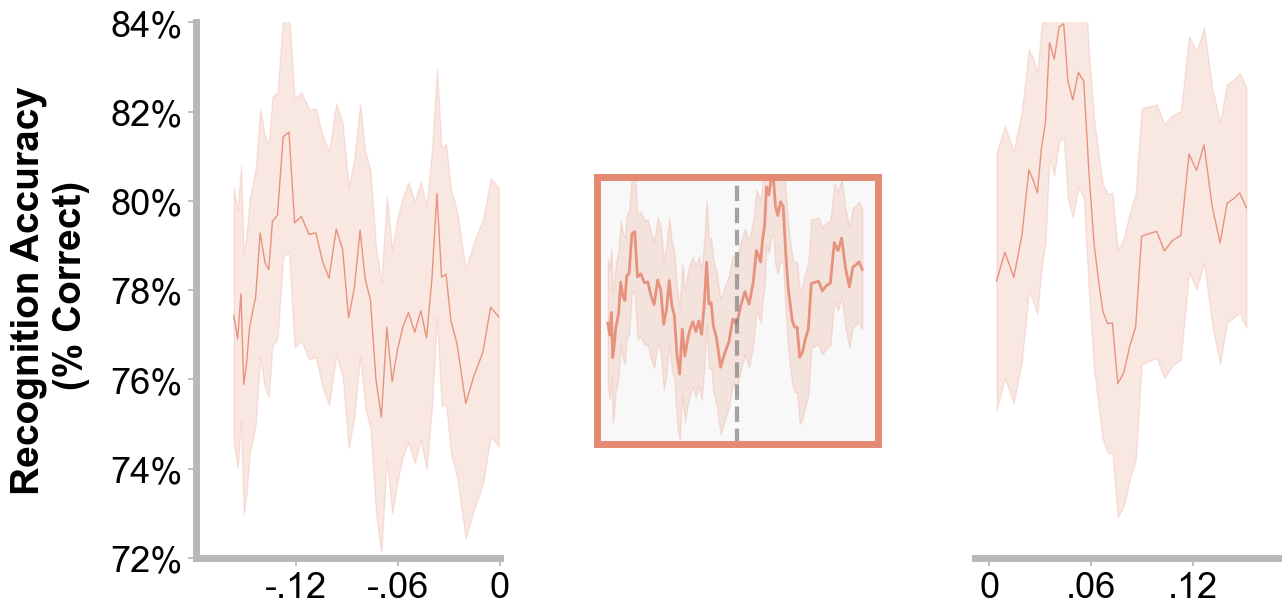

In [19]:
# For V2 data - only pass V2 model fits  
fig_v2 = create_three_panel_visualization(
    plot_configs_v2,
    middle_width=0.35,
    middle_height_shift=0.18,
    middle_size_scale=0.5,
    adjustable_gap=-0.03,
    x_buffer_percent=0.05,
    plot_model_fits = False,
    model_fits_data=model_fits_v2  # Only V2 model fits
)

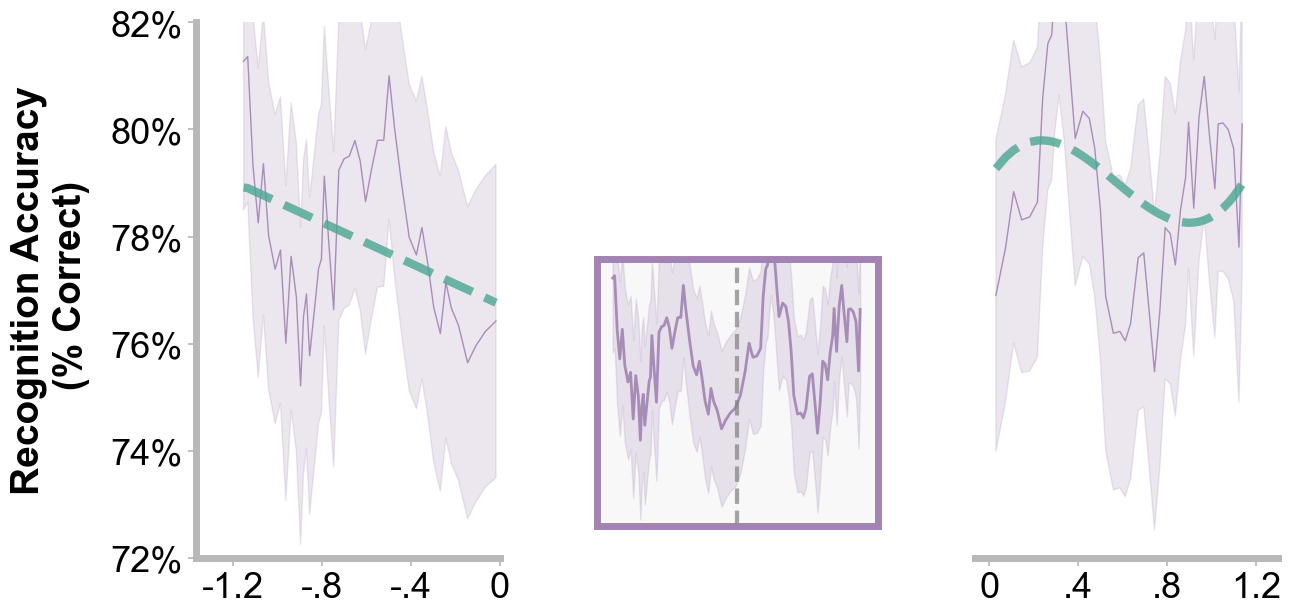

In [26]:
plot_configs_it_fixed = [
    {
        'df': df,
        'x_col': 'LTM - NonLTM IT Distractor Similarity',
        'y_col': "LTM Accuracy",
        # 'item_col': "Tested Item",
        'y_label': "Recognition Accuracy\n (% Correct)",

        'split_col': "IT_pos_neg",
        'split_value': 0.7,
        'y_limits': (0.72, 0.82),
        'x_limits': (-1.3, 1.3),
        'x_tick_step': 0.4,
        'left_model_order': 3,
        'right_model_order': 3,
        'trim_percentile': 0,
        'y_as_percentage': True,
        'y_percentage_step': 2,
        'font_family': 'Arial',
        'label_font_size': 28,  # UPDATED: Match second code
        'tick_font_size': 26    # UPDATED: Match second code
    }
    , 
    {
        'df': df,
        'x_col': 'LTM - NonLTM IT Distractor Similarity',
        'y_col': "LTM Accuracy",
        # 'item_col': "Tested Item", 
        'y_label': "Recognition Accuracy\n (% Correct)",

        'split_col': "IT_pos_neg",
        'split_value': 0.7,
        'y_limits': (0.72, 0.82),
        'x_limits': (-1.3, 1.3),
        'x_tick_step': 0.4,
        'left_model_order': 3,
        'right_model_order': 3,
        'trim_percentile': 0,
        'y_as_percentage': True,
        'y_percentage_step': 2,
        'font_family': 'Arial',
        'label_font_size': 28,  # UPDATED: Match second code
        'tick_font_size': 26    # UPDATED: Match second code
    }, 
    {
        'df': df,
        'x_col': 'LTM - NonLTM IT Distractor Similarity',
        'y_col': "LTM Accuracy",       
        'y_label': "Recognition Accuracy\n (% Correct)",

        # 'item_col': "Tested Item",
        'split_col': "IT_pos_neg",
        'split_value': 0.7,
        'y_limits': (0.72, 0.82),
        'x_limits': (-1.3, 1.3),
        'x_tick_step': 0.4,
        'left_model_order': 3,
        'right_model_order': 3,
        'trim_percentile': 0,
        'y_as_percentage': True,
        'y_percentage_step': 2,
        'font_family': 'Arial',
        'label_font_size': 28,  # UPDATED: Match second code
        'tick_font_size': 26    # UPDATED: Match second code
    }
]
plot_configs_v2 = [
    {
        'df': df,
        'x_col': 'LTM - NonLTM V2 Distractor Similarity',
        'y_col': "LTM Accuracy",
        'y_label': "Recognition Accuracy\n (% Correct)",
        'split_col': "V2_pos_neg",
        'split_value': 0,
        'y_limits': (0.72, 0.82), # Custom y-axis limits
        'x_limits': (-0.17, 0.17),   # Combined x limits
        'x_tick_step': 0.04,           # X-axis ticks every 0.04
        'left_model_order': 3,         # 3rd order polynomial for left side
        'right_model_order': 3,        # 3rd order polynomial for right side
        'trim_percentile': 0,          # Remove extreme 0% from each tail
        'y_as_percentage': True,       # Format as percentages
        'y_percentage_step': 2,        # Every 2%
        'font_family': 'Arial',
        'label_font_size': 28,         # Increased from 14
        'tick_font_size': 26           # Increased from 12
    }
    , 
    {
        'df': df,
        'x_col': 'LTM - NonLTM V2 Distractor Similarity',
        'y_col': "LTM Accuracy",
        'y_label': "Recognition Accuracy\n (% Correct)",
        'split_col': "V2_pos_neg",
        'split_value': 0,
        'y_limits': (0.72, 0.82), # Custom y-axis limits
        'x_limits': (-0.17, 0.17),   # Combined x limits
        'x_tick_step': 0.04,           # X-axis ticks every 0.04
        'left_model_order': 3,         # 3rd order polynomial for left side
        'right_model_order': 3,        # 3rd order polynomial for right side
        'trim_percentile': 0,          # Remove extreme 0% from each tail
        'y_as_percentage': True,       # Format as percentages
        'y_percentage_step': 2,        # Every 2%
        'font_family': 'Arial',
        'label_font_size': 28,         # Increased from 14
        'tick_font_size': 26           # Increased from 12
    }
    ,
    {
        'df': df,
        'x_col': 'LTM - NonLTM V2 Distractor Similarity',
        'y_col': "LTM Accuracy",
        'y_label': "Recognition Accuracy\n (% Correct)",
        'split_col': "V2_pos_neg",
        'split_value': 0,
        'y_limits': (0.72, 0.82), # Custom y-axis limits
        'x_limits': (-0.17, 0.17),   # Combined x limits
        'x_tick_step': 0.04,           # X-axis ticks every 0.04
        'left_model_order': 3,         # 3rd order polynomial for left side
        'right_model_order': 3,        # 3rd order polynomial for right side
        'trim_percentile': 0,          # Remove extreme 0% from each tail
        'y_as_percentage': True,       # Format as percentages
        'y_percentage_step': 2,        # Every 2%
        'font_family': 'Arial',
        'label_font_size': 28,         # Increased from 14
        'tick_font_size': 26           # Increased from 12
    }
]


model_fits_it = load_model_fits('experiment_accuracy_fits_it_pil5')
model_fits_v2 = load_model_fits('experiment_accuracy_fits_v2_pil5')
# Call the function with the updated settings to match second code
fig_it = create_three_panel_visualization(
    plot_configs_it_fixed,
    middle_width=0.35,
    middle_height_shift=0.05,
    middle_size_scale=0.5,
    adjustable_gap=-0.03,
    x_buffer_percent=0.05,
    model_fits_data=model_fits_it  # Only IT model fits
)

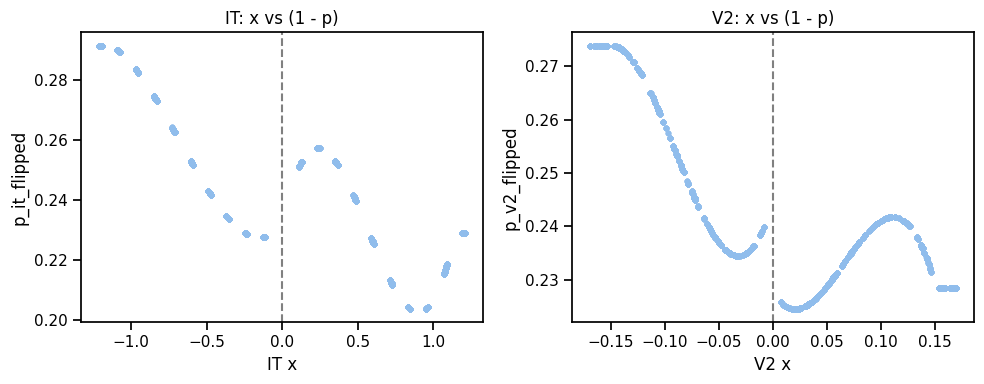

0       0.231488
1       0.236110
2       0.271835
3       0.262438
4       0.236617
          ...   
7328    0.245281
7329    0.238379
7330    0.241647
7331    0.235767
7332    0.268678
Name: p_values_v2_flipped_ltm, Length: 7333, dtype: float64

In [21]:

def _flipped_p_from_model(model_fits_data, row_idx, x_vals):
    """
    Vectorized: for each x in x_vals, look up the matching side ('left' if x<=0 else 'right')
    and interpolate 1 - y from the first model stored for that side.
    """
    x_vals = np.asarray(x_vals, dtype=float)
    out = np.full(x_vals.shape, np.nan, dtype=float)

    row_key = f"row_{row_idx}"
    mf = model_fits_data[row_key]['model_fits']

    for side, mask in (('left', x_vals <= 0), ('right', x_vals > 0)):
        if not np.any(mask): 
            continue
        side_dict = mf.get(f"{side}_side", {})
        if not side_dict:
            continue
        first_key = next(iter(side_dict))
        fit = side_dict[first_key]
        x_fit = np.asarray(fit['x_values'], dtype=float)
        y_fit = np.asarray(fit['y_values'], dtype=float)
        out[mask] = np.interp(x_vals[mask], x_fit, 1.0 - y_fit)  # clamps at edges
    return out

def attach_flipped_ps(df, it_x_col, v2_x_col, model_fits_it, model_fits_v2, row_idx=1):
    """
    Adds:
      - p_it_flipped: 1 - p(x) from experiment_accuracy_fits_it at each row's IT x
      - p_v2_flipped: 1 - p(x) from experiment_accuracy_fits_v2 at each row's V2 x
    Uses the exact interpolation logic used for the regression.
    """
    out = df.copy()
    out['p_it_flipped'] = _flipped_p_from_model(model_fits_it, row_idx, out[it_x_col].to_numpy())
    out['p_v2_flipped'] = _flipped_p_from_model(model_fits_v2, row_idx, out[v2_x_col].to_numpy())
    return out

def quick_check_plot(df, it_x_col, v2_x_col):
    """Tiny sanity check: scatter x vs flipped p for IT and V2."""
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].scatter(df[it_x_col], df['p_it_flipped'], s=10, alpha=0.6)
    ax[0].axvline(0, ls='--', c='grey'); ax[0].set_title('IT: x vs (1 - p)')
    ax[0].set_xlabel('IT x'); ax[0].set_ylabel('p_it_flipped')

    ax[1].scatter(df[v2_x_col], df['p_v2_flipped'], s=10, alpha=0.6)
    ax[1].axvline(0, ls='--', c='grey'); ax[1].set_title('V2: x vs (1 - p)')
    ax[1].set_xlabel('V2 x'); ax[1].set_ylabel('p_v2_flipped')

    plt.tight_layout(); plt.show()
    
enhanced = attach_flipped_ps(
    df,
    it_x_col='LTM - NonLTM IT Distractor Similarity',
    v2_x_col='LTM - NonLTM V2 Distractor Similarity',
    model_fits_it=model_fits_it,
    model_fits_v2=model_fits_v2,
    row_idx=1  # same row index you used for plotting
)

quick_check_plot(
    enhanced,
    it_x_col='LTM - NonLTM IT Distractor Similarity',
    v2_x_col='LTM - NonLTM V2 Distractor Similarity'
)

enhanced['p_values_v2_flipped_ltm'] = enhanced['p_v2_flipped']
enhanced['p_values_it_flipped_ltm'] = enhanced['p_it_flipped']

enhanced.to_csv("enhanced_df_pilot5.csv", index=False)
enhanced['p_values_v2_flipped_ltm']

In [44]:


# def extract_data_from_model_fits(model_fits_dict):
    
#     all_data = []
    
#     for row_key, row_data in model_fits_dict.items():
#         if 'model_fits' not in row_data:
#             continue
            
#         if 'left_side' in row_data['model_fits']:
#             for model_key, model_info in row_data['model_fits']['left_side'].items():
#                 x_vals = np.array(model_info['x_values'])
#                 y_vals = np.array(model_info['y_values'])
                
#                 p_vals_flipped = 1 - y_vals  
#                 p_vals = y_vals  
                
#                 for i in range(len(x_vals)):
#                     all_data.append({
#                         'x_values': x_vals[i],
#                         'y_values': y_vals[i], 
#                         'p_values': p_vals[i],
#                         'p_values_flipped': p_vals_flipped[i],
#                         'item_name': model_info['item_name'],
#                         'side': 'left',
#                         'row': row_key
#                     })
        
#         if 'right_side' in row_data['model_fits']:
#             for model_key, model_info in row_data['model_fits']['right_side'].items():
#                 x_vals = np.array(model_info['x_values'])
#                 y_vals = np.array(model_info['y_values'])
#                 p_vals_flipped = 1 - y_vals  
#                 p_vals = y_vals  
#                 for i in range(len(x_vals)):
#                     all_data.append({
#                         'x_values': x_vals[i],
#                         'y_values': y_vals[i],
#                         'p_values': p_vals[i], 
#                         'p_values_flipped': p_vals_flipped[i],
#                         'item_name': model_info['item_name'],
#                         'side': 'right',
#                         'row': row_key
#                     })
    
#     return pd.DataFrame(all_data)

# def add_pvalue_columns_from_model_fits(df, model_fits_it=None, model_fits_v2=None):

    
#     df_enhanced = df.copy()
    
#     if model_fits_it is not None:
#         it_x_col = 'LTM - NonLTM IT Distractor Similarity'
        
#         print("Extracting IT p-values from model fits...")
        
#         if it_x_col in df.columns:
#             it_experiment_df = extract_data_from_model_fits(model_fits_it)
            
#             if len(it_experiment_df) > 0:
#                 print(f"  Extracted {len(it_experiment_df)} IT data points")
                
#                 df_enhanced['p_values_it_ltm'] = map_single_pvalue_column(
#                     df, it_x_col, it_experiment_df, 'x_values', 'p_values'
#                 )
#                 print(f"  Added p_values_it_ltm: range [{df_enhanced['p_values_it_ltm'].min():.3f}, {df_enhanced['p_values_it_ltm'].max():.3f}]")
                
#                 df_enhanced['p_values_it_flipped_ltm'] = map_single_pvalue_column(
#                     df, it_x_col, it_experiment_df, 'x_values', 'p_values_flipped'
#                 )
#                 print(f"  Added p_values_it_flipped_ltm: range [{df_enhanced['p_values_it_flipped_ltm'].min():.3f}, {df_enhanced['p_values_it_flipped_ltm'].max():.3f}]")
#             else:
#                 print("  WARNING: No IT data extracted from model fits")
#         else:
#             print(f"  WARNING: Column '{it_x_col}' not found in main dataframe")
    
#     if model_fits_v2 is not None:
#         v2_x_col = 'LTM - NonLTM V2 Distractor Similarity'
        
#         print("Extracting V2 p-values from model fits...")
        
#         if v2_x_col in df.columns:
#             v2_experiment_df = extract_data_from_model_fits(model_fits_v2)
            
#             if len(v2_experiment_df) > 0:
#                 print(f"  Extracted {len(v2_experiment_df)} V2 data points")
                
#                 df_enhanced['p_values_v2_ltm'] = map_single_pvalue_column(
#                     df, v2_x_col, v2_experiment_df, 'x_values', 'p_values'
#                 )
#                 print(f"  Added p_values_v2_ltm: range [{df_enhanced['p_values_v2_ltm'].min():.3f}, {df_enhanced['p_values_v2_ltm'].max():.3f}]")
                
#                 df_enhanced['p_values_v2_flipped_ltm'] = map_single_pvalue_column(
#                     df, v2_x_col, v2_experiment_df, 'x_values', 'p_values_flipped'
#                 )
#                 print(f"  Added p_values_v2_flipped_ltm: range [{df_enhanced['p_values_v2_flipped_ltm'].min():.3f}, {df_enhanced['p_values_v2_flipped_ltm'].max():.3f}]")
#             else:
#                 print("  WARNING: No V2 data extracted from model fits")
#         else:
#             print(f"  WARNING: Column '{v2_x_col}' not found in main dataframe")
    
#     print(f"\nOriginal df shape: {df.shape}")
#     print(f"Enhanced df shape: {df_enhanced.shape}")
#     print(f"New columns added: {[col for col in df_enhanced.columns if col not in df.columns]}")
    
#     return df_enhanced

# def map_single_pvalue_column(df, x_col, experiment_df, exp_x_col, exp_p_col):
    
#     exp_x = experiment_df[exp_x_col].values
#     exp_p = experiment_df[exp_p_col].values
    
#     valid_mask = ~(np.isnan(exp_x) | np.isnan(exp_p))
#     exp_x_clean = exp_x[valid_mask]
#     exp_p_clean = exp_p[valid_mask]
    
#     if len(exp_x_clean) == 0:
#         print(f"    WARNING: No valid data for {exp_p_col}")
#         return np.full(len(df), np.nan)
    
#     sort_idx = np.argsort(exp_x_clean)
#     exp_x_sorted = exp_x_clean[sort_idx]
#     exp_p_sorted = exp_p_clean[sort_idx]
    
#     data_x = df[x_col].values
#     interpolated_p = np.interp(data_x, exp_x_sorted, exp_p_sorted)
    
#     print(f"    {exp_p_col}: exp_data range x=[{exp_x_sorted.min():.3f}, {exp_x_sorted.max():.3f}], p=[{exp_p_sorted.min():.3f}, {exp_p_sorted.max():.3f}]")
#     print(f"    {exp_p_col}: interpolated range p=[{interpolated_p.min():.3f}, {interpolated_p.max():.3f}]")
    
#     return interpolated_p

# def load_model_fits_and_create_enhanced_df(df, it_filename='experiment_accuracy_fits_it', v2_filename='experiment_accuracy_fits_v2'):
    
#     try:
#         # Load IT model fits
#         print(f"Loading IT model fits from {it_filename}...")
#         model_fits_it = load_model_fits(it_filename)  # Your existing function
#         print(f"  Loaded {len(model_fits_it)} IT rows")
#     except Exception as e:
#         print(f"  Could not load IT model fits: {e}")
#         model_fits_it = None
    
#     try:
#         # Load V2 model fits
#         print(f"Loading V2 model fits from {v2_filename}...")
#         model_fits_v2 = load_model_fits(v2_filename)  # Your existing function  
#         print(f"  Loaded {len(model_fits_v2)} V2 rows")
#     except Exception as e:
#         print(f"  Could not load V2 model fits: {e}")
#         model_fits_v2 = None
    
#     # Add p-value columns
#     df_enhanced = add_pvalue_columns_from_model_fits(df, model_fits_it, model_fits_v2)
    
#     return df_enhanced

# df_enhanced = add_pvalue_columns_from_model_fits(
#     df, 
#     model_fits_it=model_fits_it,  
#     model_fits_v2=model_fits_v2    
# )
# #
# df_enhanced.to_csv("correct_wm_ltm_p.csv", index=False)


In [22]:
print("Columns in df_enhanced:")
pvalue_columns = [col for col in enhanced.columns if 'p_values' in col]
print(pvalue_columns)

if len(pvalue_columns) > 0:
    for col in pvalue_columns:
        print(f"{col}: {enhanced[col].describe()}")


Columns in df_enhanced:
['p_values_it', 'p_values_it_flipped', 'p_values_v2', 'p_values_v2_flipped', 'p_values_it_flipped_ltm', 'p_values_v2_flipped_ltm']
p_values_it: count    7333.000000
mean        0.755179
std         0.028903
min         0.691821
25%         0.740392
50%         0.758203
75%         0.777124
max         0.796790
Name: p_values_it, dtype: float64
p_values_it_flipped: count    7333.000000
mean        0.244821
std         0.028903
min         0.203210
25%         0.222876
50%         0.241797
75%         0.259608
max         0.308179
Name: p_values_it_flipped, dtype: float64
p_values_v2: count    7333.000000
mean        0.758047
std         0.017279
min         0.723523
25%         0.749645
50%         0.759804
75%         0.767005
max         0.793816
Name: p_values_v2, dtype: float64
p_values_v2_flipped: count    7333.000000
mean        0.241953
std         0.017279
min         0.206184
25%         0.232995
50%         0.240196
75%         0.250355
max         0.27

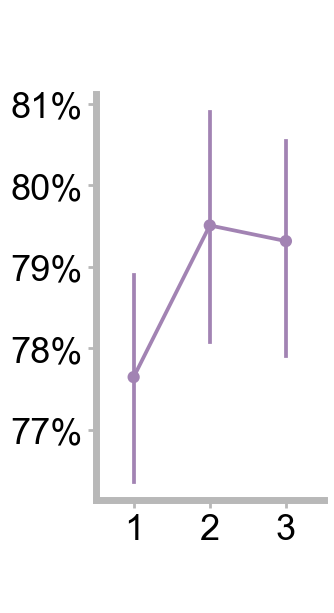

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import FuncFormatter, MultipleLocator

def remove_leading_zero_formatter(x, pos):
    """Custom formatter to remove leading zeros from tick labels"""
    if x == 0:
        return '0'
    elif x > 0:
        formatted = f'{x:.2f}'.rstrip('0').rstrip('.')
        if formatted.startswith('0.'):
            return formatted[1:]
        return formatted
    else:
        formatted = f'{x:.2f}'.rstrip('0').rstrip('.')
        if formatted.startswith('-0.'):
            return '-' + formatted[2:]
        return formatted

def get_data_type_colors():
    """Get colors matching the second code's color scheme"""
    return {
        'IT': '#A283B3',   # Purple for IT 
        'V2': '#E58A72'    # Salmon for V2
    }

def analyze_pvalue_bins_simple(df_enhanced, data_type='IT', pvalue_type='regular', 
                              accuracy_col='LTM Accuracy', subject_col='participant', n_bins=3):
   
    if data_type == 'IT':
        posneg_col = 'it_pos_neg_ltm'
        if pvalue_type == 'regular':
            pvalue_col = 'p_values_it_ltm'
        elif pvalue_type == 'flipped':
            pvalue_col = 'p_values_it_flipped_ltm'
        else:
            raise ValueError("pvalue_type must be 'regular' or 'flipped'")
            
    elif data_type == 'V2':
        posneg_col = 'v2_pos_neg_ltm'
        if pvalue_type == 'regular':
            pvalue_col = 'p_values_v2_ltm'
        elif pvalue_type == 'flipped':
            pvalue_col = 'p_values_v2_flipped_ltm'
        else:
            raise ValueError("pvalue_type must be 'regular' or 'flipped'")
    else:
        raise ValueError("data_type must be 'IT' or 'V2'")
    
    if pvalue_col not in df_enhanced.columns:
        raise ValueError(f"Column '{pvalue_col}' not found in dataframe. Available p-value columns: {[col for col in df_enhanced.columns if 'p_values' in col]}")
    
    X = df_enhanced[posneg_col].values.reshape(-1, 1)
    y = df_enhanced[accuracy_col].values
    
    reg = LinearRegression().fit(X, y)
    predicted = reg.predict(X)
    regressed_accuracy = y - predicted + np.mean(y)  
    
    df_work = df_enhanced.copy()
    df_work['regressed_accuracy'] = regressed_accuracy
    
    results = []
    
    subjects = df_work[subject_col].unique()
    
    for subject in subjects:
        subj_data = df_work[df_work[subject_col] == subject].copy()
        
        if len(subj_data) == 0:
            continue
            
        p_min, p_max = subj_data[pvalue_col].min(), subj_data[pvalue_col].max()
        
        if p_min == p_max:  
            middle_bin = (n_bins + 1) // 2  # Define middle_bin for equal values
            subj_data['p_bin'] = middle_bin
        else:
            try:
                subj_data['p_bin'] = pd.qcut(subj_data[pvalue_col], q=n_bins, labels=range(1, n_bins + 1))
            except ValueError:
                bins = np.linspace(p_min, p_max, n_bins + 1)
                subj_data['p_bin'] = pd.cut(subj_data[pvalue_col], bins=bins, labels=range(1, n_bins + 1), include_lowest=True)
        
        for bin_num in range(1, n_bins + 1):
            bin_data = subj_data[subj_data['p_bin'] == bin_num]
            if len(bin_data) > 0:
                avg_regressed_acc = bin_data['regressed_accuracy'].mean()
                results.append({
                    'subject': subject,
                    'p_bin': bin_num,
                    'regressed_accuracy': avg_regressed_acc,
                    'n_trials': len(bin_data),
                    'p_bin_min': bin_data[pvalue_col].min(),
                    'p_bin_max': bin_data[pvalue_col].max()
                })
    
    return pd.DataFrame(results)

def plot_pvalue_analysis(results_df, data_type='IT', pvalue_type='regular', n_bins=3, 
                        figsize=(7, 8), y_as_percentage=True):
    """
    Create P-value analysis plot with styling to match the second code
    """
    
    # Get colors matching the second code
    colors = get_data_type_colors()
    color = colors[data_type]
    
    # Create figure with specified size (narrower)
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set background color
    ax.set_facecolor('white')
    
    # Create the pointplot with custom styling (bigger points, heavier lines, no caps)
    sns.pointplot(data=results_df, x='p_bin', y='regressed_accuracy', 
                  errorbar='se', capsize=0, color=color, ax=ax,
                  linewidth=5, markersize=12)
    
    # Styling to match second code
    font_family = 'Arial'
    label_font_size = 28
    tick_font_size = 26
    title_font_size = 30
    spine_color = '#B8B8B8'
    
    # Set labels with matching styling (renamed to WM competition)
    if data_type == 'IT':
        ax.set_xlabel('   ', 
                     fontfamily=font_family, fontsize=label_font_size, 
                     fontweight='bold', color='black', labelpad=15)
    else:
        ax.set_xlabel('   ', 
                     fontfamily=font_family, fontsize=label_font_size, 
                   fontweight='bold', color='black', labelpad=15)
    
    if y_as_percentage:
        ax.set_ylabel('', 
                     fontfamily=font_family, fontsize=label_font_size, 
                     fontweight='bold', color='black', labelpad=15)
        # Format y-axis as percentage
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
    else:
        ax.set_ylabel('Regressed LTM Accuracy', 
                     fontfamily=font_family, fontsize=label_font_size, 
                     fontweight='bold', color='black', labelpad=15)
    
    # Set title with matching styling
    ax.set_title("   \n   \n  \n ")
    
    # Style the spines to match second code
    for spine_name in ['top', 'right']:
        ax.spines[spine_name].set_visible(False)
    
    for spine_name in ['bottom', 'left']:
        ax.spines[spine_name].set_color(spine_color)
        ax.spines[spine_name].set_linewidth(5)
    
    # Style ticks to match second code
    ax.tick_params(axis='x', colors=spine_color, labelsize=tick_font_size, 
                   labelcolor='black', width=2, length=6)
    ax.tick_params(axis='y', colors=spine_color, labelsize=tick_font_size, 
                   labelcolor='black', width=2, length=6)
    
    # Set font family for tick labels
    for label in ax.get_xticklabels():
        label.set_fontfamily(font_family)
    for label in ax.get_yticklabels():
        label.set_fontfamily(font_family)
    
    # Set x-tick labels
    ax.set_xticks(range(n_bins))
    ax.set_xticklabels([str(i+1) for i in range(n_bins)])
  #  ax.set_ylim(0.72, 0.8)
   # ax.set_yticks([0.72, 0.74, 0.76,0.78, 0.8])
    
    # Apply custom formatter to x-axis if needed
    #ax.xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    # Remove grid
    ax.grid(False)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def run_complete_analysis(df_enhanced, data_type='IT', pvalue_type='regular', n_bins=3,
                         figsize=(7, 8), y_as_percentage=True):
    """
    Run complete analysis with updated styling
    """
    
    results = analyze_pvalue_bins_simple(
        df_enhanced=df_enhanced,
        data_type=data_type,
        pvalue_type=pvalue_type,
        accuracy_col='LTM Accuracy',
        subject_col='participant', 
        n_bins=n_bins
    )
    
    fig = plot_pvalue_analysis(results, data_type, pvalue_type, n_bins, 
                              figsize=figsize, y_as_percentage=y_as_percentage)
    
    return results, fig

def create_pvalue_scatter_plot(df_enhanced, data_type='IT', pvalue_type='regular',
                              figsize=(12, 8), y_as_percentage=True):
    """
    Create P-value scatter plot with styling to match the second code
    """
    
    if data_type == 'IT':
        posneg_col = 'it_pos_neg_ltm'
        pvalue_col = 'p_values_it_ltm' if pvalue_type == 'regular' else 'p_values_it_flipped_ltm'
    elif data_type == 'V2':
        posneg_col = 'v2_pos_neg_ltm'  
        pvalue_col = 'p_values_v2_ltm' if pvalue_type == 'regular' else 'p_values_v2_flipped_ltm'
    else:
        raise ValueError("data_type must be 'IT' or 'V2'")
    
    accuracy_col = 'LTM Accuracy'
    subject_col = 'participant'
    n_bins = 10  
    
    subject_dummies = pd.get_dummies(df_enhanced[subject_col], prefix='subj')
    
    X_pos_neg = df_enhanced[posneg_col].values.reshape(-1, 1)
    X_full = np.column_stack([X_pos_neg, subject_dummies.values])
    y = df_enhanced[accuracy_col].values
    
    reg = LinearRegression().fit(X_full, y)
    predicted = reg.predict(X_full)
    regressed_accuracy = y - predicted + np.mean(y)
    
    scatter_data = []
    subjects = df_enhanced[subject_col].unique()
    
    for subject in subjects:
        subj_mask = df_enhanced[subject_col] == subject
        subj_p_values = df_enhanced.loc[subj_mask, pvalue_col].values
        subj_regressed_acc = regressed_accuracy[subj_mask]
        
        if len(subj_p_values) == 0:
            continue
            
        p_min, p_max = subj_p_values.min(), subj_p_values.max()
        
        if p_min == p_max:
            bin_assignments = np.full(len(subj_p_values), 5)
        else:
            bin_edges = np.linspace(p_min, p_max, n_bins + 1)
            bin_assignments = np.digitize(subj_p_values, bin_edges) - 1
            bin_assignments = np.clip(bin_assignments, 0, n_bins - 1)  
        
        for bin_num in range(n_bins):
            bin_mask = bin_assignments == bin_num
            if np.any(bin_mask):
                avg_regressed_acc = subj_regressed_acc[bin_mask].mean()
                scatter_data.append({
                    'subject': subject,
                    'bin_num': bin_num + 1,  
                    'regressed_accuracy': avg_regressed_acc,
                    'data_type': data_type
                })
    
    scatter_df = pd.DataFrame(scatter_data)
    
    # Get colors matching the second code
    colors = get_data_type_colors()
    color = colors[data_type]
    
    # Create the lmplot with enhanced styling
    g = sns.lmplot(data=scatter_df, 
                   x='bin_num', 
                   y='regressed_accuracy',
                   scatter_kws={'color': color, 'alpha': 0.8, 's': 60, 
                               'edgecolors': 'white', 'linewidth': 1.5},
                   line_kws={'color': '#BFBFBF', 'linewidth': 4},  # Grey fit line
                   ci=95,
                   height=figsize[1], 
                   aspect=figsize[0]/figsize[1])
    
    # Styling to match second code
    font_family = 'Arial'
    label_font_size = 28
    tick_font_size = 26
    title_font_size = 30
    spine_color = '#B8B8B8'
    
    # Access the main axis
    ax = g.ax
    
    # Set background color
    ax.set_facecolor('white')
    
    # Set labels with matching styling
    if data_type == 'IT':
        ax.set_xlabel('IT Probability of Accurate Working Memory', 
                     fontfamily=font_family, fontsize=label_font_size, 
                     fontweight='bold', color='black', labelpad=15)
    else:
        ax.set_xlabel('V2 Probability of Accurate Working Memory', 
                     fontfamily=font_family, fontsize=label_font_size, 
                     fontweight='bold', color='black', labelpad=15)
    
    if y_as_percentage:
        ax.set_ylabel('', 
                     fontfamily=font_family, fontsize=label_font_size, 
                     fontweight='bold', color='black', labelpad=15)
        # Format y-axis as percentage
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
    else:
        ax.set_ylabel('Later Memory Accuracy', 
                     fontfamily=font_family, fontsize=label_font_size, 
                     fontweight='bold', color='black', labelpad=15)
    
    # Set title with matching styling
    g.fig.suptitle(f'{data_type} P-Value Scatter Plot ({pvalue_type})\nEach point = one subject\'s bin average', 
                   fontfamily=font_family, fontsize=title_font_size, 
                   fontweight='bold', color='black', y=1.02)
    
    # Style the spines to match second code
    for spine_name in ['top', 'right']:
        ax.spines[spine_name].set_visible(False)
    
    for spine_name in ['bottom', 'left']:
        ax.spines[spine_name].set_color(spine_color)
        ax.spines[spine_name].set_linewidth(5)
    
    # Style ticks to match second code
    ax.tick_params(axis='x', colors=spine_color, labelsize=tick_font_size, 
                   labelcolor='black', width=2, length=6)
    ax.tick_params(axis='y', colors=spine_color, labelsize=tick_font_size, 
                   labelcolor='black', width=2, length=6)
    
    # Set font family for tick labels
    for label in ax.get_xticklabels():
        label.set_fontfamily(font_family)
    for label in ax.get_yticklabels():
        label.set_fontfamily(font_family)
    
    # Set x-ticks and apply custom formatter
    ax.set_xticks(range(1, n_bins + 1))
    ax.xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    # Remove default grid
    ax.grid(False)
    
    plt.tight_layout()
    plt.show()
    
    correlation = scatter_df['bin_num'].corr(scatter_df['regressed_accuracy'])
    
    return scatter_df, g.fig

# Example usage with updated styling:
results_it, fig_it = run_complete_analysis(enhanced, data_type='IT', pvalue_type='flipped', 
                                           n_bins=3, figsize=(3.5, 6.3), y_as_percentage=True)
# results_v2, fig_v2 = run_complete_analysis(enhanced, data_type='V2', pvalue_type='flipped', 
#                                           n_bins=3, figsize=(12, 8), y_as_percentage=True)

# scatter_df_it, fig_scatter_it = create_pvalue_scatter_plot(df_enhanced, data_type='IT', 
#                                                           pvalue_type='regular', figsize=(12, 8), 
#                                                           y_as_percentage=True)
# scatter_df_v2, fig_scatter_v2 = create_pvalue_scatter_plot(df_enhanced, data_type='V2', 
#                                                           pvalue_type='regular', figsize=(12, 8), 
#                                                           y_as_percentage=True)

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import FuncFormatter, MultipleLocator

def remove_leading_zero_formatter(x, pos):
    """Custom formatter to remove leading zeros from tick labels"""
    if x == 0:
        return '0'
    elif x > 0:
        formatted = f'{x:.2f}'.rstrip('0').rstrip('.')
        if formatted.startswith('0.'):
            return formatted[1:]
        return formatted
    else:
        formatted = f'{x:.2f}'.rstrip('0').rstrip('.')
        if formatted.startswith('-0.'):
            return '-' + formatted[2:]
        return formatted

def get_data_type_colors():
    """Get colors matching the second code's color scheme"""
    return {
        'IT': '#A283B3',   # Purple for IT 
        'V2': '#E58A72'    # Salmon for V2
    }

def analyze_pvalue_bins_simple(df_enhanced, data_type='IT', pvalue_type='regular', 
                              accuracy_col='LTM Accuracy', subject_col='participant', n_bins=3):
   
    if data_type == 'IT':
        posneg_col = 'it_pos_neg_ltm'
        if pvalue_type == 'regular':
            pvalue_col = 'p_values_it_ltm'
        elif pvalue_type == 'flipped':
            pvalue_col = 'p_values_it_flipped_ltm'
        else:
            raise ValueError("pvalue_type must be 'regular' or 'flipped'")
            
    elif data_type == 'V2':
        posneg_col = 'v2_pos_neg_ltm'
        if pvalue_type == 'regular':
            pvalue_col = 'p_values_v2_ltm'
        elif pvalue_type == 'flipped':
            pvalue_col = 'p_values_v2_flipped_ltm'
        else:
            raise ValueError("pvalue_type must be 'regular' or 'flipped'")
    else:
        raise ValueError("data_type must be 'IT' or 'V2'")
    
    if pvalue_col not in df_enhanced.columns:
        raise ValueError(f"Column '{pvalue_col}' not found in dataframe. Available p-value columns: {[col for col in df_enhanced.columns if 'p_values' in col]}")
    
    X = df_enhanced[posneg_col].values.reshape(-1, 1)
    y = df_enhanced[accuracy_col].values
    
    reg = LinearRegression().fit(X, y)
    predicted = reg.predict(X)
    regressed_accuracy = y - predicted + np.mean(y)  
    
    df_work = df_enhanced.copy()
    df_work['regressed_accuracy'] = regressed_accuracy
    
    results = []
    
    subjects = df_work[subject_col].unique()
    
    for subject in subjects:
        subj_data = df_work[df_work[subject_col] == subject].copy()
        
        if len(subj_data) == 0:
            continue
            
        p_min, p_max = subj_data[pvalue_col].min(), subj_data[pvalue_col].max()
        
        if p_min == p_max:  
            middle_bin = (n_bins + 1) // 2  # Define middle_bin for equal values
            subj_data['p_bin'] = middle_bin
        else:
            try:
                subj_data['p_bin'] = pd.qcut(subj_data[pvalue_col], q=n_bins, labels=range(1, n_bins + 1))
            except ValueError:
                bins = np.linspace(p_min, p_max, n_bins + 1)
                subj_data['p_bin'] = pd.cut(subj_data[pvalue_col], bins=bins, labels=range(1, n_bins + 1), include_lowest=True)
        
        for bin_num in range(1, n_bins + 1):
            bin_data = subj_data[subj_data['p_bin'] == bin_num]
            if len(bin_data) > 0:
                avg_regressed_acc = bin_data['regressed_accuracy'].mean()
                results.append({
                    'subject': subject,
                    'p_bin': bin_num,
                    'regressed_accuracy': avg_regressed_acc,
                    'n_trials': len(bin_data),
                    'p_bin_min': bin_data[pvalue_col].min(),
                    'p_bin_max': bin_data[pvalue_col].max()
                })
    
    return pd.DataFrame(results)

def plot_pvalue_analysis(results_df, data_type='IT', pvalue_type='regular', n_bins=3, 
                        figsize=(7, 8), y_as_percentage=True):
    """
    Create P-value analysis plot with enhanced styling
    """
    
    # Get colors matching the second code
    colors = get_data_type_colors()
    color = colors[data_type]
    
    # Create figure with specified size (narrower)
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set background color
    ax.set_facecolor('white')
    
    # Create the pointplot with enhanced styling (bigger points, heavier lines, no caps)
    sns.pointplot(data=results_df, x='p_bin', y='regressed_accuracy', 
                  errorbar='se', capsize=0, color=color, ax=ax,
                  linewidth=5, markersize=12)
    
    # Styling to match second code
    font_family = 'Arial'
    label_font_size = 28
    tick_font_size = 26
    title_font_size = 30
    spine_color = '#B8B8B8'
    
    # Set labels with matching styling (renamed to WM competition)
    if data_type == 'IT':
        ax.set_xlabel('IT WM competition', 
                     fontfamily=font_family, fontsize=label_font_size, 
                     fontweight='bold', color='black', labelpad=15)
    else:
        ax.set_xlabel('V2 WM competition', 
                     fontfamily=font_family, fontsize=label_font_size, 
                     fontweight='bold', color='black', labelpad=15)
    
    if y_as_percentage:
        ax.set_ylabel('Recognition Accuracy\n(% Correct)', 
                     fontfamily=font_family, fontsize=label_font_size, 
                     fontweight='bold', color='black', labelpad=15)
        # Format y-axis as percentage
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
    else:
        ax.set_ylabel('Regressed LTM Accuracy', 
                     fontfamily=font_family, fontsize=label_font_size, 
                     fontweight='bold', color='black', labelpad=15)
    
    # Set title with matching styling
    ax.set_title(f"{data_type} WM Competition Analysis ({pvalue_type}, {n_bins} bins)", 
                fontfamily=font_family, fontsize=title_font_size, 
                fontweight='bold', color='black', pad=20)
    
    # Style the spines to match second code
    for spine_name in ['top', 'right']:
        ax.spines[spine_name].set_visible(False)
    
    for spine_name in ['bottom', 'left']:
        ax.spines[spine_name].set_color(spine_color)
        ax.spines[spine_name].set_linewidth(5)
    
    # Style ticks to match second code
    ax.tick_params(axis='x', colors=spine_color, labelsize=tick_font_size, 
                   labelcolor='black', width=2, length=6)
    ax.tick_params(axis='y', colors=spine_color, labelsize=tick_font_size, 
                   labelcolor='black', width=2, length=6)
    
    # Set font family for tick labels
    for label in ax.get_xticklabels():
        label.set_fontfamily(font_family)
    for label in ax.get_yticklabels():
        label.set_fontfamily(font_family)
    
    # Set x-tick labels
    ax.set_xticks(range(n_bins))
    ax.set_xticklabels([str(i+1) for i in range(n_bins)])
    
    # Apply custom formatter to x-axis if needed
    ax.xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    # Remove grid
    ax.grid(False)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def run_complete_analysis(df_enhanced, data_type='IT', pvalue_type='regular', n_bins=3,
                         figsize=(7, 8), y_as_percentage=True):
    """
    Run complete analysis with updated styling
    """
    
    results = analyze_pvalue_bins_simple(
        df_enhanced=df_enhanced,
        data_type=data_type,
        pvalue_type=pvalue_type,
        accuracy_col='LTM Accuracy',
        subject_col='participant', 
        n_bins=n_bins
    )
    
    fig = plot_pvalue_analysis(results, data_type, pvalue_type, n_bins, 
                              figsize=figsize, y_as_percentage=y_as_percentage)
    
    return results, fig

def create_pvalue_scatter_plot(df_enhanced, data_type='IT', pvalue_type='regular',
                              figsize=(7, 8), y_as_percentage=True):
    """
    Create P-value scatter plot with enhanced styling
    """
    
    if data_type == 'IT':
        posneg_col = 'it_pos_neg_ltm'
        pvalue_col = 'p_values_it_ltm' if pvalue_type == 'regular' else 'p_values_it_flipped_ltm'
    elif data_type == 'V2':
        posneg_col = 'v2_pos_neg_ltm'  
        pvalue_col = 'p_values_v2_ltm' if pvalue_type == 'regular' else 'p_values_v2_flipped_ltm'
    else:
        raise ValueError("data_type must be 'IT' or 'V2'")
    
    accuracy_col = 'LTM Accuracy'
    subject_col = 'participant'
    n_bins = 10  
    
    subject_dummies = pd.get_dummies(df_enhanced[subject_col], prefix='subj')
    
    X_pos_neg = df_enhanced[posneg_col].values.reshape(-1, 1)
    X_full = np.column_stack([X_pos_neg, subject_dummies.values])
    y = df_enhanced[accuracy_col].values
    
    reg = LinearRegression().fit(X_full, y)
    predicted = reg.predict(X_full)
    regressed_accuracy = y - predicted + np.mean(y)
    
    scatter_data = []
    subjects = df_enhanced[subject_col].unique()
    
    for subject in subjects:
        subj_mask = df_enhanced[subject_col] == subject
        subj_p_values = df_enhanced.loc[subj_mask, pvalue_col].values
        subj_regressed_acc = regressed_accuracy[subj_mask]
        
        if len(subj_p_values) == 0:
            continue
            
        p_min, p_max = subj_p_values.min(), subj_p_values.max()
        
        if p_min == p_max:
            bin_assignments = np.full(len(subj_p_values), 5)
        else:
            bin_edges = np.linspace(p_min, p_max, n_bins + 1)
            bin_assignments = np.digitize(subj_p_values, bin_edges) - 1
            bin_assignments = np.clip(bin_assignments, 0, n_bins - 1)  
        
        for bin_num in range(n_bins):
            bin_mask = bin_assignments == bin_num
            if np.any(bin_mask):
                avg_regressed_acc = subj_regressed_acc[bin_mask].mean()
                scatter_data.append({
                    'subject': subject,
                    'bin_num': bin_num + 1,  
                    'regressed_accuracy': avg_regressed_acc,
                    'data_type': data_type
                })
    
    scatter_df = pd.DataFrame(scatter_data)
    
    # Get colors matching the second code
    colors = get_data_type_colors()
    color = colors[data_type]
    
    # Create the lmplot with enhanced styling (narrower, bigger points, heavier line)
    g = sns.lmplot(data=scatter_df, 
                   x='bin_num', 
                   y='regressed_accuracy',
                   scatter_kws={'color': color, 'alpha': 0.8, 's': 100, 
                               'edgecolors': 'white', 'linewidth': 2},
                   line_kws={'color': '#BFBFBF', 'linewidth': 6},  # Heavier grey fit line
                   ci=95,
                   height=figsize[1], 
                   aspect=figsize[0]/figsize[1])
    
    # Styling to match second code
    font_family = 'Arial'
    label_font_size = 28
    tick_font_size = 26
    title_font_size = 30
    spine_color = '#B8B8B8'
    
    # Access the main axis
    ax = g.ax
    
    # Set background color
    ax.set_facecolor('white')
    
    # Set labels with matching styling (renamed to WM competition)
    if data_type == 'IT':
        ax.set_xlabel('IT WM competition', 
                     fontfamily=font_family, fontsize=label_font_size, 
                     fontweight='bold', color='black', labelpad=15)
    else:
        ax.set_xlabel('V2 WM competition', 
                     fontfamily=font_family, fontsize=label_font_size, 
                     fontweight='bold', color='black', labelpad=15)
    
    if y_as_percentage:
        ax.set_ylabel('Recognition Accuracy\n(% Correct)', 
                     fontfamily=font_family, fontsize=label_font_size, 
                     fontweight='bold', color='black', labelpad=15)
        # Format y-axis as percentage
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
    else:
        ax.set_ylabel('Later Memory Accuracy', 
                     fontfamily=font_family, fontsize=label_font_size, 
                     fontweight='bold', color='black', labelpad=15)
    
    # Set title with matching styling
    g.fig.suptitle(f'{data_type} WM Competition Scatter Plot ({pvalue_type})\nEach point = one subject\'s bin average', 
                   fontfamily=font_family, fontsize=title_font_size, 
                   fontweight='bold', color='black', y=1.02)
    
    # Style the spines to match second code
    for spine_name in ['top', 'right']:
        ax.spines[spine_name].set_visible(False)
    
    for spine_name in ['bottom', 'left']:
        ax.spines[spine_name].set_color(spine_color)
        ax.spines[spine_name].set_linewidth(5)
    
    # Style ticks to match second code
    ax.tick_params(axis='x', colors=spine_color, labelsize=tick_font_size, 
                   labelcolor='black', width=2, length=6)
    ax.tick_params(axis='y', colors=spine_color, labelsize=tick_font_size, 
                   labelcolor='black', width=2, length=6)
    
    # Set font family for tick labels
    for label in ax.get_xticklabels():
        label.set_fontfamily(font_family)
    for label in ax.get_yticklabels():
        label.set_fontfamily(font_family)
    
    # Set x-ticks and apply custom formatter
    ax.set_xticks(range(1, n_bins + 1))
    ax.xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    # Remove default grid
    ax.grid(False)
    
    plt.tight_layout()
    plt.show()
    
    correlation = scatter_df['bin_num'].corr(scatter_df['regressed_accuracy'])
    
    return scatter_df, g.fig

# Example usage with updated styling:
# results_it, fig_it = run_complete_analysis(df_enhanced, data_type='IT', pvalue_type='regular', 
#                                           n_bins=3, figsize=(7, 8), y_as_percentage=True)
# results_v2, fig_v2 = run_complete_analysis(df_enhanced, data_type='V2', pvalue_type='regular', 
#                                           n_bins=4, figsize=(7, 8), y_as_percentage=True)

# scatter_df_it, fig_scatter_it = create_pvalue_scatter_plot(df_enhanced, data_type='IT', 
#                                                           pvalue_type='regular', figsize=(7, 8), 
#                                                           y_as_percentage=True)
# scatter_df_v2, fig_scatter_v2 = create_pvalue_scatter_plot(df_enhanced, data_type='V2', 
#                                                           pvalue_type='regular', figsize=(7, 8), 
#                                                           y_as_percentage=True)

In [48]:
 # Example usage with updated styling:
results_it, fig_it = run_complete_analysis(df_enhanced, data_type='IT', pvalue_type='regular', 
                                           n_bins=3, figsize=(12, 8), y_as_percentage=True)
# results_v2, fig_v2 = run_complete_analysis(df_enhanced, data_type='V2', pvalue_type='regular', 
#                                           n_bins=4, figsize=(12, 8), y_as_percentage=True)

#scatter_df_it, fig_scatter_it = create_pvalue_scatter_plot(df_enhanced, data_type='IT', 
 #                                                          pvalue_type='regular', figsize=(12, 8), 
  #                                                         y_as_percentage=True)
# scatter_df_v2, fig_scatter_v2 = create_pvalue_scatter_plot(df_enhanced, data_type='V2', 
#                                                           pvalue_type='regular', figsize=(12, 8), 
#                                                           y_as_percentage=True)

NameError: name 'df_enhanced' is not defined

In [ ]:
# df_enhanced.to_csv("correct_wm_ltm_p.csv", index=False)